# Compute the mid Holocene temperature anomaly

This notebooks computes GMST using Generalized Additive Models (GAM). 

The main output is a netCDF file `annual-with-single-seas-gam-band-means.nc` with the temperature anomaly with reference to the 5000-3000 year BP period for the six latitudinal bands -90 to -60, -60 to -30, -30 to 0, 0 to 30, 30 to 60 and 60 to 90 degrees North.

This notebook is divided into three sections.

1. [Read the LiPD files](#lipds)
2. [Transform them into a combined dataframe](#pandas)
3. [Compute the grid cell anomalies](#cell-anomalies)

Note that you have to set the [version for the database](#db_version) manually.

## Strategy for modern reference value

- calculate PI anomaly of WorldClim period using 20CRv3
- Add PI anomaly to WorldClim (to retain high-res data)
- Add PI anomaly to SST data

For every sample:

- if  sample in PI: 
      use sample
- elif variableDetail == air@surface or lake@surface:
      if WorldClim has data at site:
          use WorldClim
      else:
          use closest worldClim
          send TSid to Basil
- else:
      if SST has data at site:
          use SST
      else:
          use closest SST
          send TSid to Basil

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import os.path as osp
import os
from urllib import request
import zipfile
import time
import pickle
from openpyxl import load_workbook
import matplotlib.pyplot as plt
import importlib
import warnings
import xarray as xr
import multiprocessing as mp
import psyplot.data as psyd
import gam_ensemble as ge
import pyleogrid as pg
from distributed import Client
import psyplot.project as psy
from matplotlib.animation import FuncAnimation
import contextlib
from sklearn.neighbors import BallTree
from latlon_utils import get_climate
from dask_jobqueue import SLURMCluster
import lipd

## Read the LiPD files <a name="lipds"></a>
In this section we read the temperature from the LiPD files. This involves some [filtering](#filter) to only keep the necessary temperature series. Note however, that samples with NaN are filtered [down below](#filter-nan).

<a id=db_version></a>Read in the LipD data from http://lipdverse.org/globalHolocene/current_version

You should set the latest version here manually!

In [2]:
%matplotlib inline

In [3]:
db_version = '1_0_0'

In [4]:
fixes = importlib.import_module('fixes_' + db_version)

In [5]:
lipd_dir = f'../lipds_{db_version}'

In [6]:
output_dir = f'../output_{db_version}'
!mkdir -p {output_dir}

Download the LiPD file if the input directory does not yet exist

In [7]:
%%time
if not osp.exists(lipd_dir):
    os.makedirs(lipd_dir)
    zipped = f'Temp12k_v{db_version}_LiPD.zip'
    uri = f'https://www1.ncdc.noaa.gov/pub/data/paleo/reconstructions/climate12k/temperature/version{db_version.replace("_", ".")}/{zipped}'
    target = osp.join(lipd_dir, zipped)
    print('downloading ' + uri)
    request.urlretrieve(uri, target)
    with zipfile.ZipFile(target) as f:
        f.extractall(lipd_dir)

CPU times: user 986 µs, sys: 0 ns, total: 986 µs
Wall time: 1.22 ms


In [8]:
@contextlib.contextmanager
def remember_cwd():
    """Context manager to switch back to the current working directory

    Usage::

        with remember_cwd():
            os.chdir('test')
            print(os.getcwd())  # test
        print(os.getcwd())      # test/.."""
    curdir = os.getcwd()
    try:
        yield
    except:
        raise
    finally:
        os.chdir(curdir)

Load the data from the LiPD files it is has not yet been serialized as a pickled object.

In [9]:
%%time
pickle_file = f'{lipd_dir}/lipds.pkl'
if osp.exists(pickle_file):
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
else:
    with remember_cwd():
        os.chdir(f'{lipd_dir}/')
        data = lipd.readLipd('.')
    with open(pickle_file, 'wb') as f:
        pickle.dump(data, f)

CPU times: user 234 ms, sys: 95.3 ms, total: 329 ms
Wall time: 364 ms


Extract the individual time-series from the LiPD files

In [10]:
%%time
all_series = lipd.extractTs(data)

extracting paleoData...
extracting: GodziszewskieLake.Miotk.1986
extracting: Hudson.Clegg.2011
extracting: ParkPond1.Lynch.1998
extracting: ElGygytgynCrater.Schwamborn.2006
extracting: Dalmutladdo.Bjune.2004
extracting: GeoB10043_3.Setiawan.2015
extracting: MD99_2341.Eynaud.2009
extracting: CN01.Cheung.2017
extracting: HumberPond5.McAndrews.1989
extracting: TauldintreBrazi.Toth.2015
extracting: LagunaSaladaChiprana.EPD
extracting: PrazRodet.Shotyk.1997
extracting: SaladaPequena.EPD
extracting: Leviathan.Lachniet.2014
extracting: BloodPond.Marsicek.2013
extracting: Khatanga-12Lake.Syrykh.2017
extracting: rainbow.Clegg.2011
extracting: M77_2_024_5.Salvatteci.2019
extracting: GeoB7926_2.Kim.2012
extracting: LagoMoreno.Markgraf.2002
extracting: PolandSpring.Jacobson.Ja
extracting: MSM05-712.Muller.2013
extracting: Gammelheimvatnet.Seppa.2009
extracting: WCA3BGumboLimboMarsh.Willard.2001
extracting: NussbaumerSeen.Rsch.1995
extracting: DevonIslandGlacier.McAndrews.1984
extracting: klotjarne

extracting: brurskardstjorni.Velle.2005
extracting: BattleGround.Whitlock.1985
extracting: Sokli.Shala.2017
extracting: LiivjarveBog.Koff.1989
extracting: GeoB4905_4.Weldeab.2005
extracting: Zabieniec.Plociennik.2011
extracting: Stazersee.Heiri.2015
extracting: D13882.Tierney
extracting: Frozen.Rosenberg.2004
extracting: PupukeChironomid.VandenBos.2018
extracting: GYXO.Self.2015
extracting: BebrukasLake.Shulija.1967
extracting: MD03_2699.Rodrigues.2010
extracting: LittleLochRoag.Birks.1979
extracting: Haugtjern.Eide.2009
extracting: PC_1.Chang.2015
extracting: EDML.Stenni.2010
extracting: PlateauRemote.MosleyThompson.1996
extracting: B997_324.Castaneda.2004
extracting: M77_2_003_2.Salvatteci.2019
extracting: KNR195_5_CDH23.Bova.2015
extracting: MD79_257.Bard.1997
extracting: Decoy.Szeicz.1991
extracting: MD95_2011.Risebrobakken.2003
extracting: Ennadai-2.Nichols.1975
extracting: Gemini.Samartin.2017
extracting: Ladd.Shane.1993
extracting: Demont.Kapp.NA
extracting: MSM343300.Ouellet-Be

extracting: BN7Lake.Gajewski.1991
extracting: LagoVerdarolo.Samartin.2011
extracting: Ennadai-1.Nichols.1967
extracting: MD01_2412.Harada.2006
extracting: LagodeAjo.Allen.1996
extracting: Donvold.Nilssen.1983
extracting: GreyIslands.Cullen.2002
extracting: TanaLake.Loomis.2015
extracting: MD95_2015.Marchal.2002
extracting: LeFourneau.Barbier.1999
extracting: 165_1002C.Herbert.2000
extracting: GIK17049_6.Jung.1996
extracting: 31Lake.Eisner.1995
extracting: OregonCaves.Ersek.2012
extracting: MD02_2503.Hill.2006
extracting: VuolepNjakajaure.Heinrichs.2006
extracting: GeoB9310_4.Weldeab.2014
extracting: ODP_167_1019C.Barron.2003
extracting: JR01.Fortin.2017
extracting: Hams.Bennett.1987
extracting: Ostrowite.Milecka.2002
extracting: StaroselskyMoch.Novenko.2018
extracting: Churruca.Caniupan.2014
extracting: Sluggan.Smith.1991
extracting: Luganskoe.Kvavadze.1994
extracting: RedRock.Maher.1972
extracting: MD06_3075.Fraser.2014
extracting: LagoDellAccesa.Finsinger.2010
extracting: Hinterburgs

Filter all the series to extract the calibrated temperature series <a name="filter"></a>

In [11]:
filtered_ts_temp12k = lipd.filterTs(all_series,'paleoData_inCompilation == Temp12k')
temperatures = lipd.filterTs(filtered_ts_temp12k,'paleoData_units == degC')

Found 1319 matches from 5088 columns
Found 1276 matches from 1319 columns


In [12]:
# HACK: RPZj5YKrFr0 has been removed for the wrong reasons 
# (see data/problematic_sites_1_0_0.xlsx), so we add it here again
to_add = lipd.filterTs(all_series, 'paleoData_TSid == RPZj5YKrFr0')
assert len(to_add) == 1
temperatures += to_add

Found 1 matches from 5088 columns


## Conversion to pandas
Now that we have the time-series, we transform them to a [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). This allows us to use groupby and other database measures.

For this purpose, we first define a few meta data attributes that should be kept for every record.

- `meta_cols` is the attribute in the dictionary of the individual time series. If the attribute is within a key or list, you can separate them by a single `.`. 
  
  `paleoData_interpretation.0.seasonalityGeneral` 
  
  for instance will be interpreted as
  
  `d['paleoData_interpretation'][0]['seasonalityGeneral']`
- `meta_names` is the name of the corresponding attribute in `meta_cols` how it should be saved in the dataframe

In [13]:
meta_cols = ['geo_meanLon', 'geo_meanLat', 'dataSetName', 'paleoData_variableName', 'paleoData_TSid', 
             'paleoData_interpretation.0.seasonalityGeneral', 'paleoData_interpretation.0.variableDetail',
             'paleoData_datum', 'paleoData_proxy']
meta_names = ['lon', 'lat', 'dataSetName', 'variableName', 'TSid', 'seasonality', 'variableDetail', 
              'datum', 'proxy']

Then every dictionary in `temperatures` is converted to a pandas datafram

In [14]:
frames = []
failures = []
for d in pg.utils.log_progress(temperatures):
    if 'age' in d:
        try:
            s = pd.Series(
                np.asarray(d['paleoData_values'], dtype=float),
                index=pd.Index(np.asarray(d['age'], dtype=float), name='age'),
                name='temperature')
        except ValueError:
            failures.append(d)
        else:
            # keep NaN of ages, these are filtered out later
            s = s[(~np.isnan(s.index)) & (s.index > -70 ) & (s.index < 14000)]
            # if the time series has (in average) more than one sample per
            # decade, we use decadal averages
            if s.size > 1470:
                s = s.groupby(lambda i: 5 + i - (i % 10)).mean()
                s.index.name = 'age'
            s.index.name = 'age'
            frame = s.to_frame().reset_index()
            for i, name in enumerate(meta_cols):
                sub = d
                vals = name.split('.')
                name = vals[-1]
                for v in vals[:-1]:
                    sub = sub[v if isinstance(sub, dict) else int(v)]
                frame[meta_names[i]] = sub.get(name, np.nan)
            frames.append(frame)
print(f"Failed to read {len(failures)} time series")

Starting at 2020-10-02 20:21:28.574854
|████████████████████████████████████████████████████████████████████████████████| 100.0% Time left: 0.000 minutes
Finished at 2020-10-02 20:21:33.465264. Time needed: 0.082 minutes
Failed to read 0 time series


Now we concatenate everything into one large dataframe

In [15]:
df = pd.concat(frames, ignore_index=True)
df.head()

,age,temperature,lon,lat,dataSetName,variableName,TSid,seasonality,variableDetail,datum,proxy
0,212.13,-2.045714,18.55,54.09,GodziszewskieLake.Miotk.1986,temperature,RFzafiT2i0G,winter+,air@surface,abs,pollen
1,275.05,-4.110000,18.55,54.09,GodziszewskieLake.Miotk.1986,temperature,RFzafiT2i0G,winter+,air@surface,abs,pollen
2,337.83,-3.375714,18.55,54.09,GodziszewskieLake.Miotk.1986,temperature,RFzafiT2i0G,winter+,air@surface,abs,pollen
3,427.04,-2.907143,18.55,54.09,GodziszewskieLake.Miotk.1986,temperature,RFzafiT2i0G,winter+,air@surface,abs,pollen
4,515.32,-4.094286,18.55,54.09,GodziszewskieLake.Miotk.1986,temperature,RFzafiT2i0G,winter+,air@surface,abs,pollen


### Estimation of uncertainties

The age uncertainty is estimated such, that it is 50 years at 0 BP and 250 years at 12k BP

In [16]:
df['age_unc'] = 50 + df.age * (250 - 50) / 12000

The temperature uncertainty is estimated per proxy and per season <a name="temp-unc"></a>

In [17]:
uncertainties = pd.read_excel(
    '../data/proxy-uncertainties.xlsx', sheet_name='Summary', 
    index_col='proxy', usecols=[0, 1, 2, 3])
uncertainties

,summer,winter,annual
proxy,,,
pollen,2.017837,3.012946,2.105745
other microfossils/dinocyst,1.700000,1.200000,1.200000
chironomid,1.399705,NaN,NaN
other microfossils/diatoms,1.122375,NaN,NaN
other microfossils/radiolaria,1.200000,NaN,NaN
other microfossils/foraminifera,1.325000,1.412500,1.282500
alkenone,NaN,NaN,1.650000
MgCa,1.850000,1.850000,1.850000
GDGT (MBT/CBT as well as BrGDGT fractional abundance),NaN,NaN,2.902857


In [18]:
uncertainty_map = {
    'dinocyst': 'other microfossils/dinocyst',
    'pollen': 'pollen', 
    'chironomid': 'chironomid',
    'alkenone': 'alkenone',
    'GDGT': 'GDGT (MBT/CBT as well as BrGDGT fractional abundance)',
    'Mg/Ca': 'MgCa',
    'macrofossils': 'macrofossils',
    'bubble frequency': 'bubble frequency',
    'borehole': 'borehole',
    'C15 fatty alcohols': 'C15 fatty alcohols',
    'd18O': 'd18O',
    'radiolaria': 'other microfossils/radiolaria',
    'foraminifera': 'other microfossils/foraminifera',
    'dD': 'dD',
    'd13C': 'd13C',
    'diatom': 'other microfossils/diatoms',
    'isotope diffusion': 'isotope diffusion',
    'TRW': 'TRW',
    'hybrid-ice': 'hybrid-ice',
    'deterium excess': 'deterium excess',
    'gas': 'gas',
    'chlorophyll': 'chlorophyll',
    'melt layer': 'melt layer',
    '3-OH-Fatty Acids': '3-OH-Fatty Acids',
    'TEX86': 'GDGT (Tex86)',
    'LDI': 'LDI',
    'long chain diol': 'long chain diol'
}
uncertainty_map_inv = {val: key for key, val in uncertainty_map.items()}

In [19]:
df['seas'] = np.nan
seasonality = df.seasonality.fillna('')
df.loc[seasonality.str.startswith('summer'), 'seas'] = 'summer'
df.loc[seasonality.str.startswith('winter'), 'seas'] = 'winter'
df.loc[seasonality.str.startswith('annual'), 'seas'] = 'annual'

In [20]:
last = uncertainties.isnull().all(axis=1)
uncertainties = uncertainties.iloc[:np.argmax(last.values)]
# default uncertainty: 75th percentile of all values without d18O
df['temp_unc'] = 1.975877719
for proxy, row in uncertainties.iterrows():
    for seas, val in row[row.notnull().values].items():
        mask = (df.proxy == uncertainty_map_inv[proxy]) & (df.seas == seas)
        df.loc[mask.values, 'temp_unc'] = val

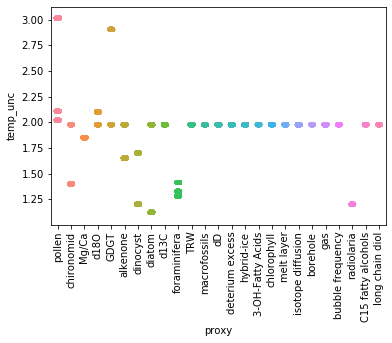

In [21]:
import seaborn as sns
ax = sns.stripplot('proxy', 'temp_unc', data=df)
for t in ax.get_xticklabels():
    t.set_rotation(90)

Now we filter out samples that have unrealistic temperatures, or no seasonality <a name="filter-nan"></a>.

In [22]:
df.loc[~df.temperature.between(-200, 200).values, 'temperature'] = np.nan

In [23]:
df.shape

(121515, 14)

## Merge modern climate information

### Preindustrial

In [24]:
with psyd.open_dataset('../data/equal-area-grid-N4000.nc') as _ds:
    output_ds = _ds.load()

In [25]:
worldclim_input = '/gpfs/work/sommerp/worldclim/tavg_30s.1850-1899.nc'

In [26]:
%%time
air_mask = df.variableDetail.isin(['air@surface', 'lake@surface'])
coords = df[air_mask].drop_duplicates('TSid')[['lat', 'lon', 'TSid']]

unique_coords = coords.drop_duplicates(['lat', 'lon'])

tavg = get_climate(
    unique_coords.lat.values, unique_coords.lon.values, ['tavg'], 
    data_files=[worldclim_input])
missing_tavg = tavg.isnull().values.any(axis=1)

print("Datasets without tavg:", missing_tavg.sum())

tavg.loc[missing_tavg, :] = get_climate(
    unique_coords.lat.values[missing_tavg], 
    unique_coords.lon.values[missing_tavg],
    ['tavg'], data_files=[worldclim_input], radius=100)
tavg[('tavg', 'missing')] = False
tavg.loc[missing_tavg, ('tavg', 'missing')] = True

still_missing_tavg = tavg.isnull().values.any(axis=1)

climate = coords.merge(tavg.reset_index(), on=['lat', 'lon'], how='left')

print("Still missing with radius 100:", still_missing_tavg.sum())

Datasets without tavg: 8
Still missing with radius 100: 1
CPU times: user 3.67 s, sys: 2.05 s, total: 5.72 s
Wall time: 2min 18s


/gpfs/home/sommerp/miniconda3/envs/temperature12k/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/gpfs/home/sommerp/miniconda3/envs/temperature12k/lib/python3.7/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [27]:
sst_input = '../external/sst.mon.mean.ltm.1850-1899.nc'

In [28]:
%%time
sst_mask = df.variableDetail.isin(['sea@surface', 'sea@subsurface'])
coords = df[sst_mask].drop_duplicates('TSid')[['lat', 'lon', 'TSid']]

unique_coords = coords.drop_duplicates(['lat', 'lon'])

sst = get_climate(unique_coords.lat.values, 
                  unique_coords.lon.values, ['sst'], 
                   data_files=[sst_input])
missing_sst = sst.isnull().values.any(axis=1)

print("Datasets without sst:", missing_sst.sum())

sst.loc[missing_sst, :] = get_climate(
    unique_coords.lat.values[missing_sst], 
    unique_coords.lon.values[missing_sst],
    ['sst'], data_files=[sst_input], radius=1)
sst[('sst', 'missing')] = False
sst.loc[missing_sst, ('sst', 'missing')] = True

still_missing_sst = sst.isnull().values.any(axis=1)

print("Still missing with radius 100:", still_missing_sst.sum())

sst.columns = tavg.columns

climate = pd.concat(
    [climate, coords.merge(sst.reset_index(), on=['lat', 'lon'], how='left')])

Datasets without sst: 3
Still missing with radius 100: 0
CPU times: user 1.09 s, sys: 1.65 s, total: 2.74 s
Wall time: 2.92 s


### Worldclim

In [29]:
worldclim_input = '/gpfs/home/sommerp/.local/share/latlon_utils/tavg_30s.nc'

In [30]:
%%time
air_mask = df.variableDetail.isin(['air@surface', 'lake@surface'])
coords = df[air_mask].drop_duplicates('TSid')[['lat', 'lon', 'TSid']]

unique_coords = coords.drop_duplicates(['lat', 'lon'])

tavg = get_climate(
    unique_coords.lat.values, unique_coords.lon.values, ['tavg'], 
    data_files=[worldclim_input])
missing_tavg = tavg.isnull().values.any(axis=1)

print("Datasets without tavg:", missing_tavg.sum())

tavg.loc[missing_tavg, :] = get_climate(
    unique_coords.lat.values[missing_tavg], 
    unique_coords.lon.values[missing_tavg],
    ['tavg'], data_files=[worldclim_input], radius=100)
tavg[('tavg', 'missing')] = False
tavg.loc[missing_tavg, ('tavg', 'missing')] = True

still_missing_tavg = tavg.isnull().values.any(axis=1)

wc_climate = coords.merge(tavg.reset_index(), on=['lat', 'lon'], how='left')

print("Still missing with radius 100:", still_missing_tavg.sum())

Datasets without tavg: 8
Still missing with radius 100: 1
CPU times: user 48.5 s, sys: 6.73 s, total: 55.2 s
Wall time: 1min 2s


In [31]:
sst_input = '../external/sst.mon.mean.ltm.1971-2000.nc'

In [32]:
%%time
sst_mask = df.variableDetail.isin(['sea@surface', 'sea@subsurface'])
coords = df[sst_mask].drop_duplicates('TSid')[['lat', 'lon', 'TSid']]

unique_coords = coords.drop_duplicates(['lat', 'lon'])

sst = get_climate(unique_coords.lat.values, 
                  unique_coords.lon.values, ['sst'], 
                   data_files=[sst_input])
missing_sst = sst.isnull().values.any(axis=1)

print("Datasets without sst:", missing_sst.sum())

sst.loc[missing_sst, :] = get_climate(
    unique_coords.lat.values[missing_sst], 
    unique_coords.lon.values[missing_sst],
    ['sst'], data_files=[sst_input], radius=1)
sst[('sst', 'missing')] = False
sst.loc[missing_sst, ('sst', 'missing')] = True

still_missing_sst = sst.isnull().values.any(axis=1)

print("Still missing with radius 100:", still_missing_sst.sum())

sst.columns = tavg.columns

wc_climate = pd.concat(
    [wc_climate, coords.merge(sst.reset_index(), on=['lat', 'lon'], how='left')])

Datasets without sst: 3
Still missing with radius 100: 0
CPU times: user 1.05 s, sys: 1.54 s, total: 2.59 s
Wall time: 2.75 s


In [33]:
wc_climate.TSid.unique().shape, wc_climate.shape

((1276,), (1276, 21))

In [34]:
new_names = {('tavg', col[1]): 'tavg_' + col[1] for col in climate.columns if col[0] == 'tavg'}

climate.rename(columns=new_names, inplace=True)
wc_climate.rename(columns=new_names, inplace=True)
climate.drop(['lat', 'lon'], inplace=True, axis=1)
wc_climate.drop(['lat', 'lon'], inplace=True, axis=1)
full_climate = climate.merge(wc_climate, on='TSid', how='left', suffixes=['_pi', '_wc'])

In [35]:
df = df.merge(full_climate, on='TSid', how='left')
df.head()

,age,temperature,lon,lat,dataSetName,variableName,TSid,seasonality,variableDetail,datum,...,tavg_sep_wc,tavg_oct_wc,tavg_nov_wc,tavg_dec_wc,tavg_djf_wc,tavg_mam_wc,tavg_jja_wc,tavg_son_wc,tavg_ann_wc,tavg_missing_wc
0,212.13,-2.045714,18.55,54.09,GodziszewskieLake.Miotk.1986,temperature,RFzafiT2i0G,winter+,air@surface,abs,...,13.0,8.3,3.0,0.0,-1.366667,7.0,16.4,8.1,7.533333,False
1,275.05,-4.110000,18.55,54.09,GodziszewskieLake.Miotk.1986,temperature,RFzafiT2i0G,winter+,air@surface,abs,...,13.0,8.3,3.0,0.0,-1.366667,7.0,16.4,8.1,7.533333,False
2,337.83,-3.375714,18.55,54.09,GodziszewskieLake.Miotk.1986,temperature,RFzafiT2i0G,winter+,air@surface,abs,...,13.0,8.3,3.0,0.0,-1.366667,7.0,16.4,8.1,7.533333,False
3,427.04,-2.907143,18.55,54.09,GodziszewskieLake.Miotk.1986,temperature,RFzafiT2i0G,winter+,air@surface,abs,...,13.0,8.3,3.0,0.0,-1.366667,7.0,16.4,8.1,7.533333,False
4,515.32,-4.094286,18.55,54.09,GodziszewskieLake.Miotk.1986,temperature,RFzafiT2i0G,winter+,air@surface,abs,...,13.0,8.3,3.0,0.0,-1.366667,7.0,16.4,8.1,7.533333,False


In [36]:
df['worldclim'] = np.nan
df['pi'] = np.nan
df['seas'] = ''

# northern hemisphere
for seas, months in [
        ('winter', 'djf'), 
        ('summer', 'jja'), 
        ('annual', 'ann')]:
    mask = df.seasonality.str.lower().str.startswith(seas) & df.seasonality.notnull() & (df.lat >= 0)
    df.loc[mask.values, 'pi'] = df.loc[mask.values, 'tavg_' + months + '_pi']
    df.loc[mask.values, 'worldclim'] = df.loc[mask.values, 'tavg_' + months + '_wc']
    df.loc[mask.values, 'seas'] = seas

# southern hemisphere
for seas, months in [
        ('winter', 'jja'), 
        ('summer', 'djf'), 
        ('annual', 'ann')]:
    mask = df.seasonality.str.lower().str.startswith(seas) & df.seasonality.notnull() & (df.lat < 0)
    df.loc[mask.values, 'pi'] = df.loc[mask.values, 'tavg_' + months + '_pi']
    df.loc[mask.values, 'worldclim'] = df.loc[mask.values, 'tavg_' + months + '_wc']
    df.loc[mask.values, 'seas'] = seas

In [37]:
df.shape

(121515, 52)

## Apply database fixes

In [38]:
df_save = df.copy(True)

In [39]:
df.set_index('TSid', inplace=True)

for func in dir(fixes):
    if func.startswith('fix_'):
        print("Applying " + func)
        fixed = getattr(fixes, func)(df)
        if fixed is not None:
            df = fixed
            
df.reset_index(inplace=True)

Applying fix_A7
Applying fix_Andy_Szeicz_1995
Dropping 51 records
Appending 57 records
Applying fix_H214
Dropping 21 records
Appending 0 records
Applying fix_MD02_2515
Applying fix_MD99_2251
Applying fix_MD99_2256_Jennings_2015
Applying fix_MV99_PC14
Applying fix_TR163_22
Applying fix_VM28_122
Applying fix_datum
Applying fix_invalid_series
Applying fix_modern_values
Applying fix_seasonality
Applying fix_single_seasons


### Recalculate temperatureComposite

In [40]:
recalc_ids = list(df.loc[
    ((df.variableName == 'temperatureComposite') &
     (df.seas == 'annual') & (df.datum.notnull())),
    'TSid'].unique())

rejected_data = df[df.TSid.isin(list(recalc_ids))]

df.set_index('TSid', inplace=True)

df = fixes.recalculate(df, recalc_ids)

df.reset_index(inplace=True)

Dropping 8997 records
Appending 8384 records


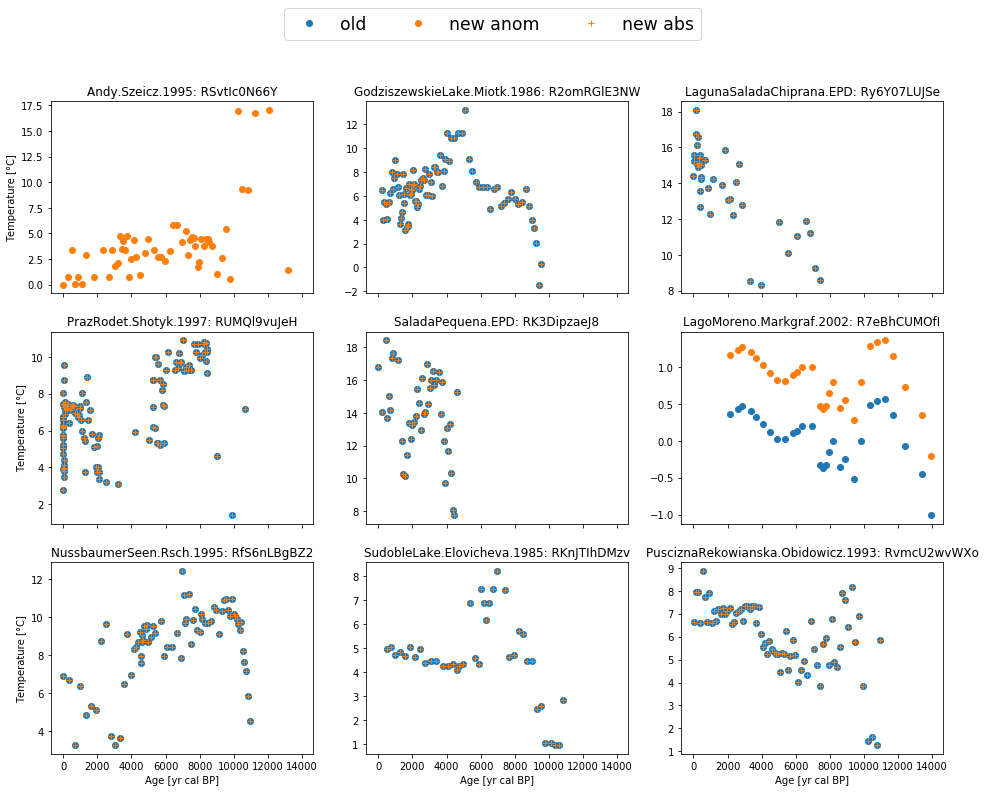

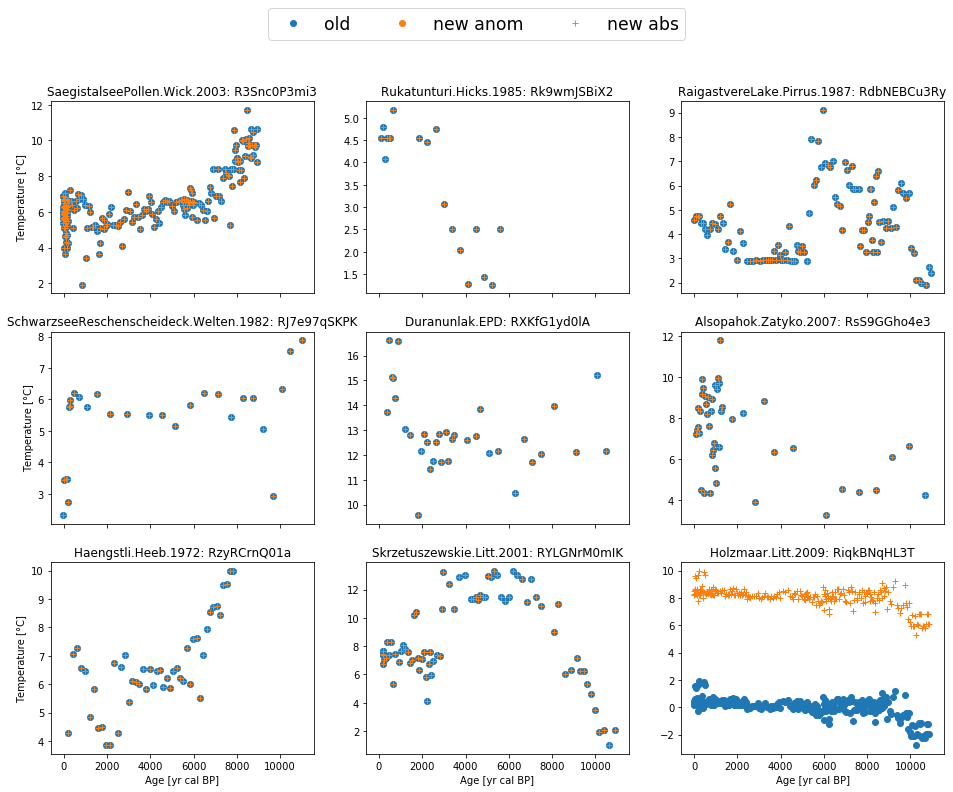

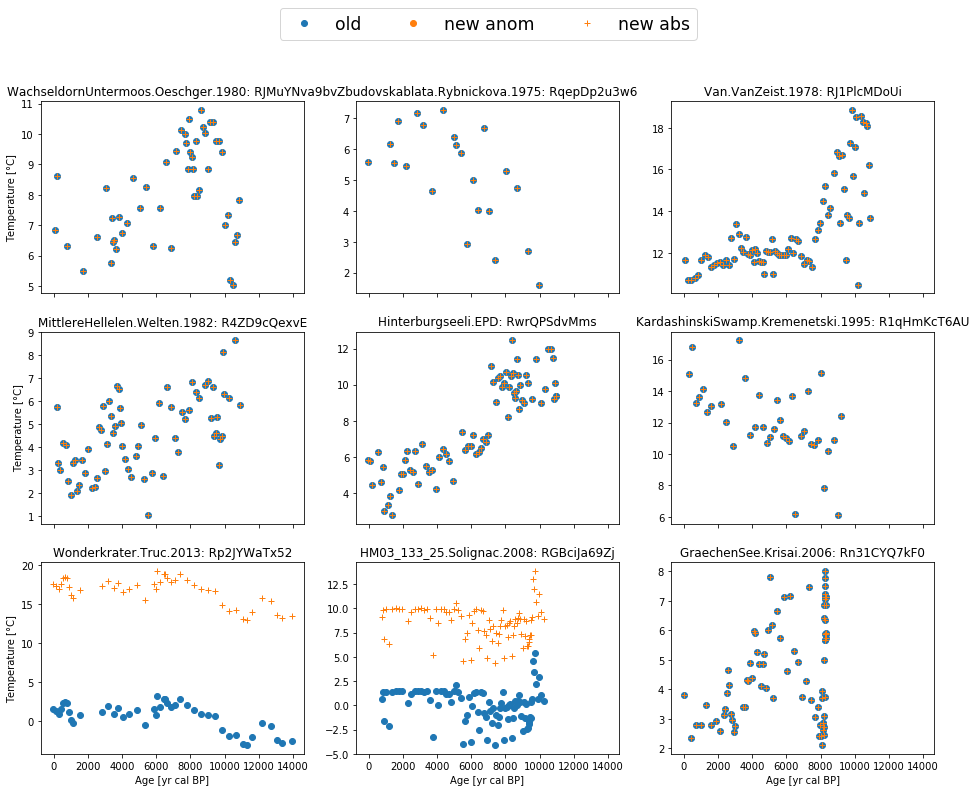

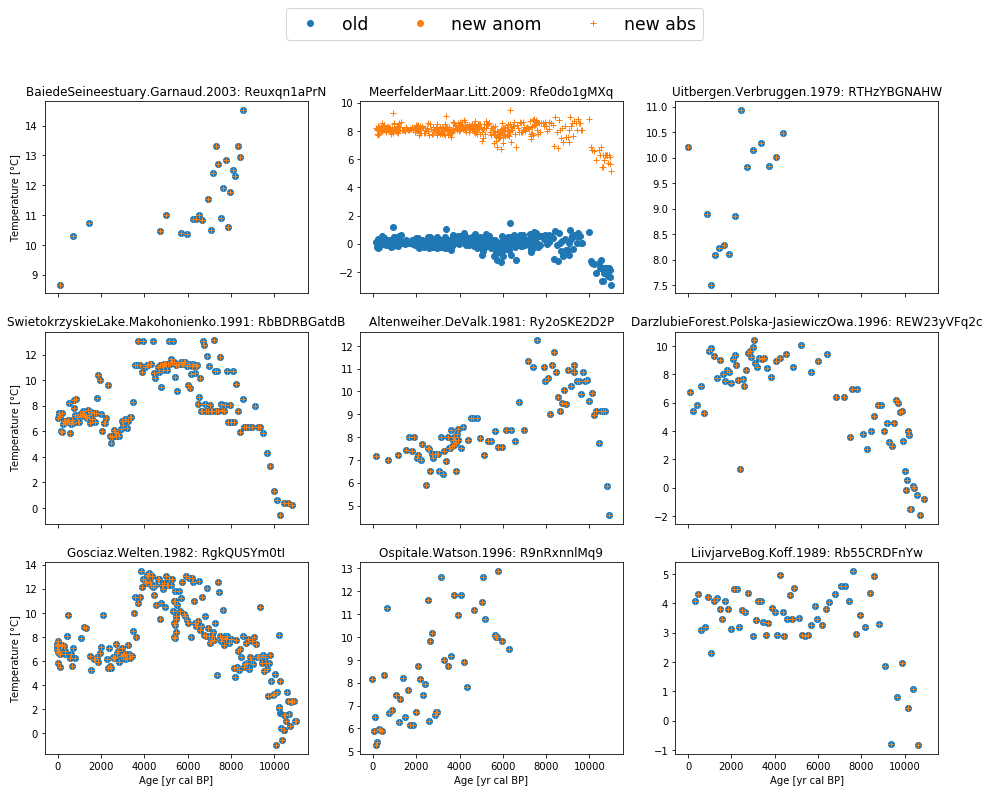

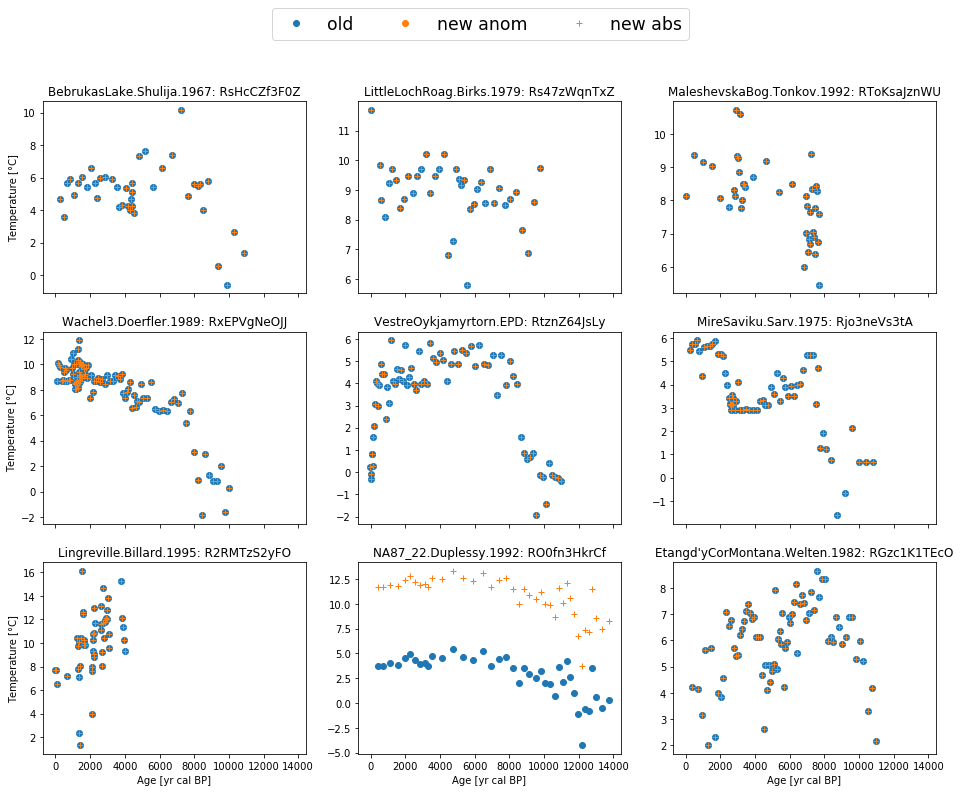

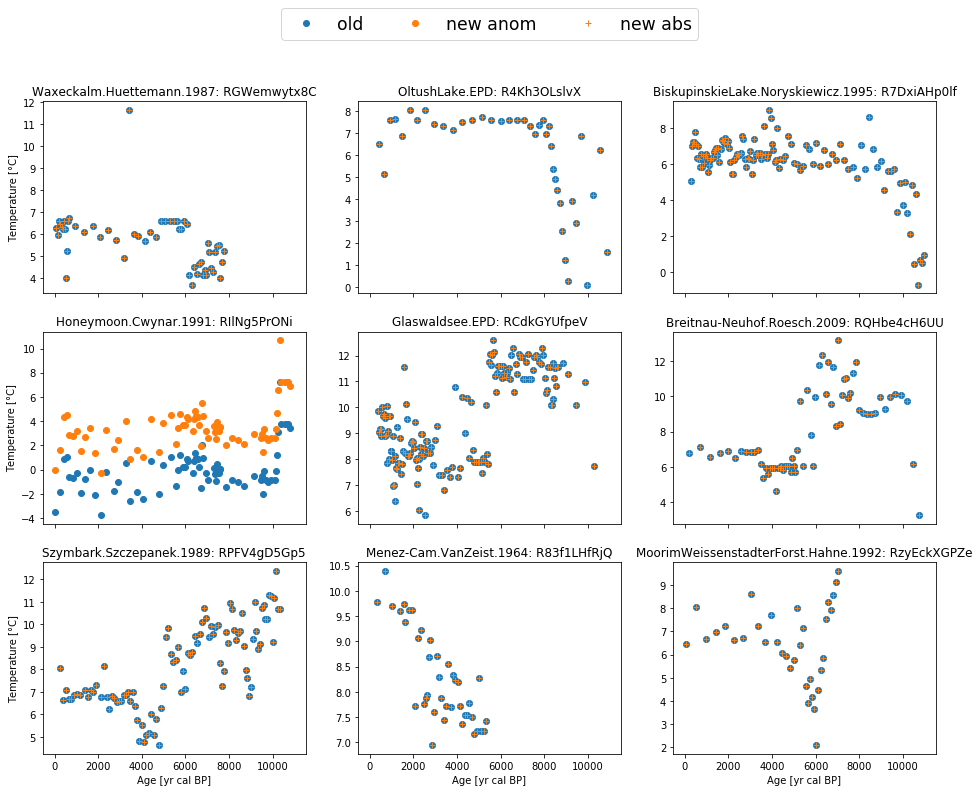

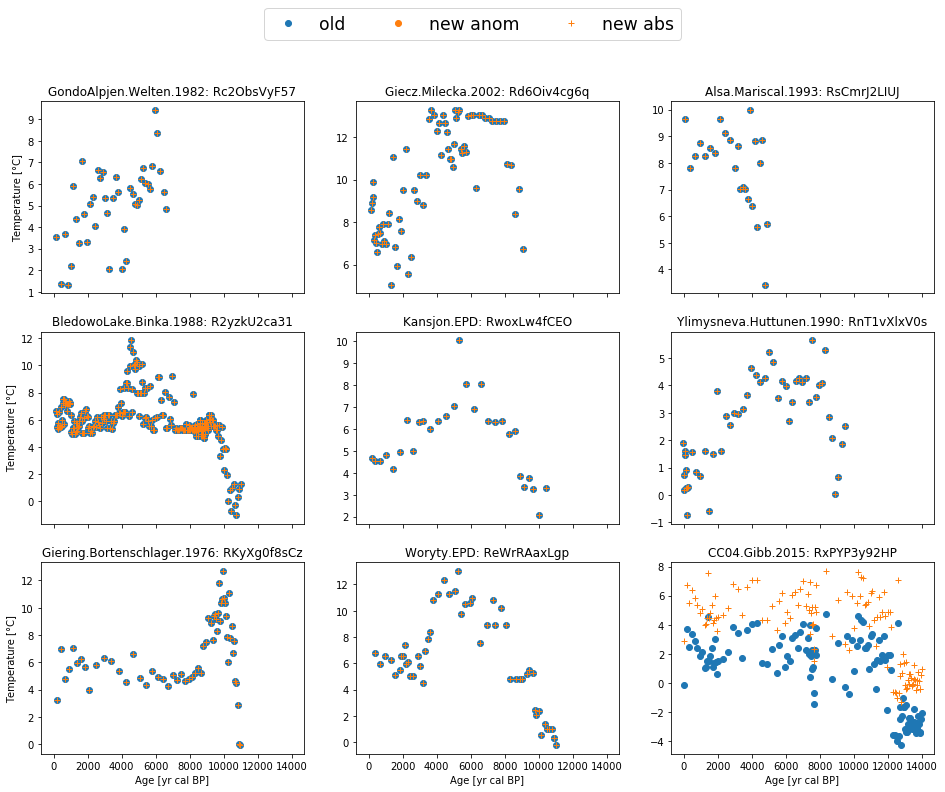

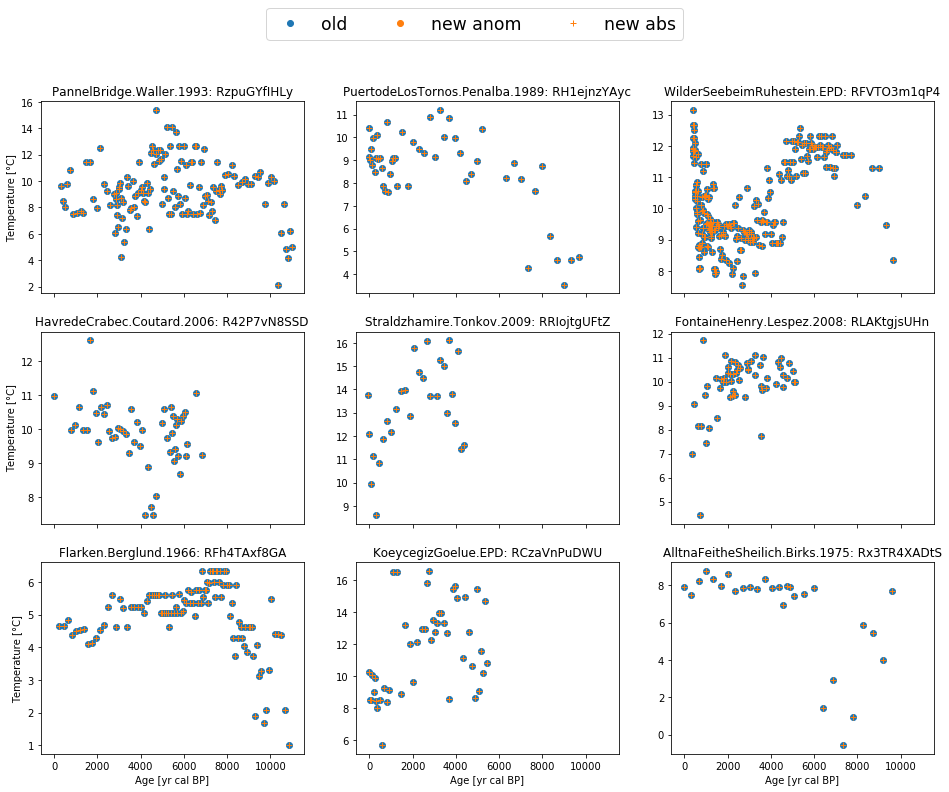

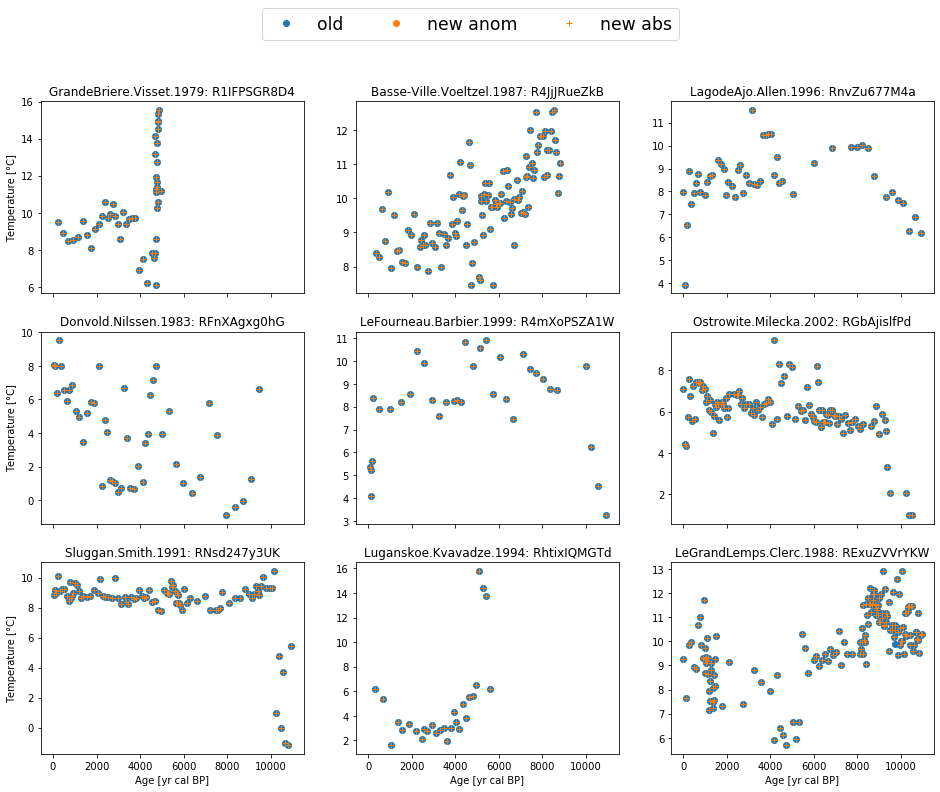

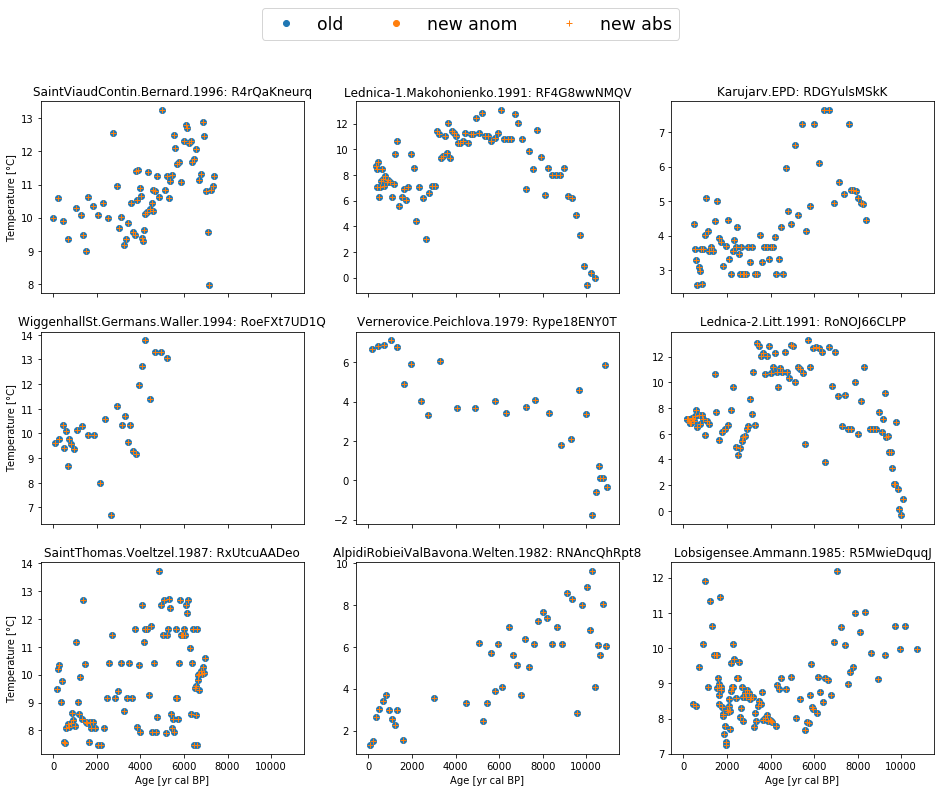

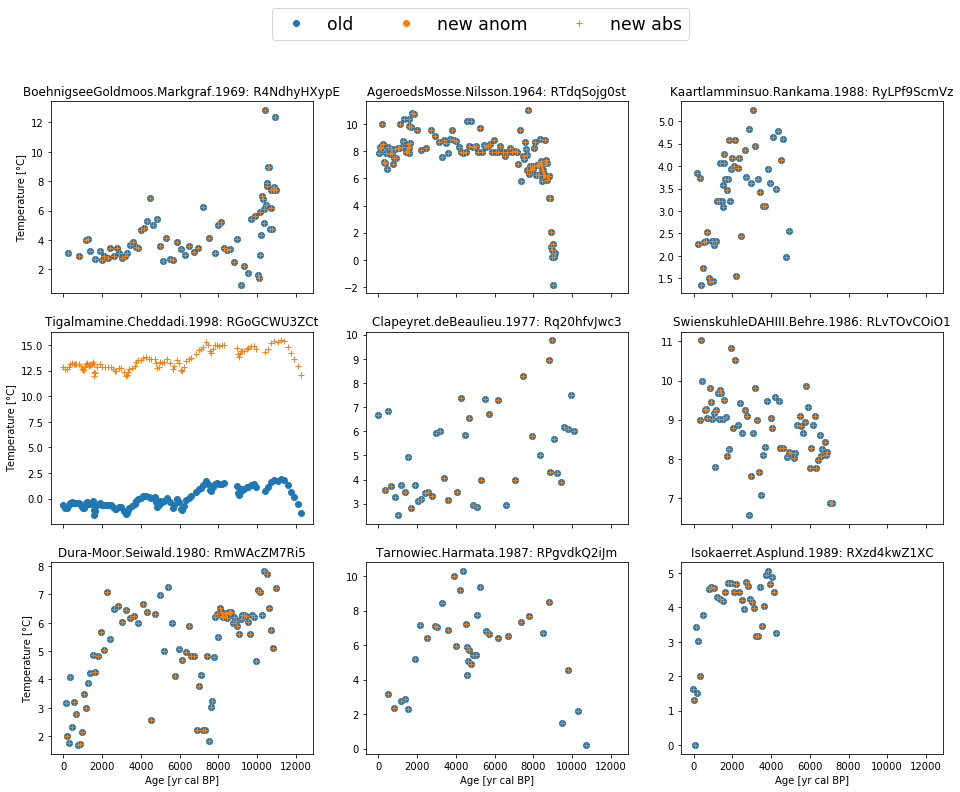

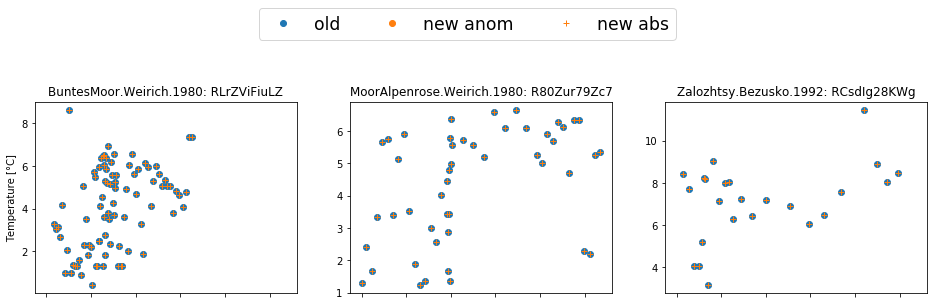

In [41]:
recalc = df.loc[df.recalculated, 'TSid'].unique()
axes = psy.multiple_subplots(3, 3, n=len(recalc), sharex=True)

artists = {}

for tsid, ax in zip(recalc, axes):
    old = rejected_data[rejected_data.TSid == tsid]
    new = df[df.TSid == tsid]
    new_marker = '+' if new.iloc[0].datum == 'abs' else 'o'
    new_label = 'new abs' if new.iloc[0].datum == 'abs' else 'new anom'
    ax.set_title(f"{new.iloc[0].dataSetName}: {tsid}")
    old_points = ax.plot(old.age, old.temperature, 'o', label='old')[0]
    new_points = ax.plot(new.age, new.temperature, new_marker, label='new')[0]
    
    artists['old'] = old_points
    artists[new_label] = new_points
    
    if ax.rowNum == 2:
        ax.set_xlabel('Age [yr cal BP]')
    if ax.colNum == 0:
        ax.set_ylabel('Temperature [°C]')
    
for fig in set(ax.figure for ax in axes):
    fig.legend(list(artists.values()), list(artists),
               ncol=3, loc='upper center', fontsize='xx-large')

In [42]:
for col in ['seasonality', 'datum', 'temperature', 'age', 'pi', 'worldclim']:
    print(f'NaN for {col}: {df[col].isnull().sum()}')

NaN for seasonality: 0
NaN for datum: 11420
NaN for temperature: 10512
NaN for age: 0
NaN for pi: 649
NaN for worldclim: 649


In [43]:
print(df.shape)
df.dropna(subset=['seasonality', 'datum', 'temperature', 'age', 'pi', 'worldclim'], 
          inplace=True)
print(df.shape)

(118781, 53)
(96232, 53)


In [44]:
df.TSid.unique().size

1173

In [45]:
with psyd.open_dataset('../data/equal-area-grid-N4000.nc') as _ds:
    output_ds = _ds.load()
area = output_ds['cell_area']
output_ds['time'] = time = xr.Variable(
    ('time', ), np.arange(12000, -50, -100),
    attrs = {'long_name': 'Age', 'units': 'years since 1950-01-01'})
output_ds['temperature'] = xr.Variable(
    ('time', area.dims[0]), np.full((time.size, area.size), np.nan),
    encoding = dict(coordinates='clat clon'))

ensemble = ge.GAMEnsemble(
    df[(df.seasonality == 'annual') | 
       (df.seasonality == 'summerOnly') | 
       (df.seasonality == 'winterOnly')].set_index('age'), 
    target=output_ds.psy['temperature'],
    climate='temperature', ds_id='TSid')

In [46]:
%%time
ds = ensemble.input_data
ages = ensemble.sample_ages(size=1000, use_dask=False)
ds['age_ensemble'] = ages.load()
ds['temperature_ensemble'] = ages.rename('temperature_ensemble').copy(
    data=np.random.normal(ds.temperature, ds.temp_unc,
                          size=ages.shape))

CPU times: user 1min 12s, sys: 444 ms, total: 1min 13s
Wall time: 1min 13s


In [47]:
output_ds['time']

<xarray.DataArray 'time' (time: 121)>
array([12000, 11900, 11800, 11700, 11600, 11500, 11400, 11300, 11200, 11100,
       11000, 10900, 10800, 10700, 10600, 10500, 10400, 10300, 10200, 10100,
       10000,  9900,  9800,  9700,  9600,  9500,  9400,  9300,  9200,  9100,
        9000,  8900,  8800,  8700,  8600,  8500,  8400,  8300,  8200,  8100,
        8000,  7900,  7800,  7700,  7600,  7500,  7400,  7300,  7200,  7100,
        7000,  6900,  6800,  6700,  6600,  6500,  6400,  6300,  6200,  6100,
        6000,  5900,  5800,  5700,  5600,  5500,  5400,  5300,  5200,  5100,
        5000,  4900,  4800,  4700,  4600,  4500,  4400,  4300,  4200,  4100,
        4000,  3900,  3800,  3700,  3600,  3500,  3400,  3300,  3200,  3100,
        3000,  2900,  2800,  2700,  2600,  2500,  2400,  2300,  2200,  2100,
        2000,  1900,  1800,  1700,  1600,  1500,  1400,  1300,  1200,  1100,
        1000,   900,   800,   700,   600,   500,   400,   300,   200,   100,
           0])
Coordinates:
  * time     (time) int64 12000 11900 11800 11700 11600 ... 400 300 200 100 0
Attributes:
    long_name:  Age
    units:      years since 1950-01-01

In [48]:
key = 'annual-with-single-seas'

In [49]:
n_workers = 64

cluster = SLURMCluster(cores=1, dashboard_address=":33913", walltime="03:00:00")
cluster.scale(n_workers)

try:
    with Client(cluster) as client:
        ensemble.align_ensembles(client=client)
        ensemble.compute_anomalies(
            client=client, modern=['pi', 'worldclim'],
            modern_young=[51, -50], modern_old=[100, -20])

        output = ensemble.predict(
            size=1000, client=client, use_gam=True, return_counts=100, max_time_diff=14000,
            return_time=True, align=False, anomalies=False)
        output['time'].values *= -1
        output.to_netcdf(f'{output_dir}/{key}-gam-ref-1850-1899-CE.nc')
finally:
    cluster.close()

Starting at 2020-10-02 20:26:50.882054


/gpfs/home/sommerp/miniconda3/envs/temperature12k/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


|████████████████████████████████████████████████████████████████████████████████| 100.0% Time left: 0.003 minutes
Finished at 2020-10-02 20:27:41.193404. Time needed: 0.839 minutes
Starting at 2020-10-02 20:27:44.978937
|████████████████████████████████████████████████████████████████████████████████| 100.0% Time left: 0.003 minutes
Finished at 2020-10-02 20:28:30.576990. Time needed: 0.760 minutes
Starting at 2020-10-02 20:28:35.056871


/gpfs/home/sommerp/miniconda3/envs/temperature12k/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


/gpfs/home/sommerp/miniconda3/envs/temperature12k/lib/python3.7/site-packages/ipykernel/zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


|████████████████████████████████████████████████████████████████████████████████| 100.0% Time left: 0.077 minutess
Finished at 2020-10-02 20:51:04.151739. Time needed: 22.485 minutes


In [50]:
output['surrounding'] = output.temperature.copy(
    data=output.nsamples.rolling(time=3, center=True).sum().values)

In [51]:
output = output.where(output['surrounding'] > 100)
del output['surrounding']

## Computation of latitudinal bands
In the last part of this analysis we compute the mean of the individual latitudinal bands. We are using an equal-area grid here, as such, we do not have to worry about the latitudinal weighting.

In [52]:
bands = []
with warnings.catch_warnings() as c:
    warnings.filterwarnings('ignore', '\s*Mean of empty slice')
    for lat in pg.utils.log_progress(np.arange(-90, 90, 30)):
        idx = np.where(output.clat - (output.clat % 30) == lat)[0]
        sel = output.isel(cell=idx)
        band = sel.mean('cell')
        
        # compute the sum for the number of samples and the cell_area
        band['nsamples'] = sel.nsamples.sum('cell')
        band['cell_area'] = sel.cell_area.sum('cell')
        band['lat'] = ((), lat + 15)
        bands.append(band)
bands = xr.concat(bands, dim='lat')

Starting at 2020-10-02 20:51:33.778580
|████████████████████████████████████████████████████████████████████████████████| 100.0% Time left: 0.024 minutes
Finished at 2020-10-02 20:51:41.497721. Time needed: 0.129 minutes


Compute the standard deviation from the ensemble

In [53]:
bands['temperature_std'] = bands.temperature_samples.std('ens')

/gpfs/home/sommerp/miniconda3/envs/temperature12k/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Plot the anomalies of the individual bands

In [54]:
output

<xarray.Dataset>
Dimensions:              (bnds: 4, cell: 4000, ens: 1000, time: 121)
Coordinates:
    clon                 (cell) float64 0.0 25.71 77.14 ... -64.28 -12.85 0.0
    clon_bnds            (cell, bnds) float64 0.0 360.0 360.0 ... 360.0 0.0
    clat                 (cell) float64 -89.09 -86.53 -86.53 ... 86.53 89.09
    clat_bnds            (cell, bnds) float64 -90.0 -90.0 -88.19 ... 90.0 90.0
  * time                 (time) int64 -12000 -11900 -11800 ... -200 -100 0
Dimensions without coordinates: bnds, cell, ens
Data variables:
    cell_area            (cell, time) float64 nan nan nan nan ... nan nan nan
    temperature          (time, cell) float64 nan nan nan nan ... nan nan nan
    temperature_samples  (time, ens, cell) float64 nan nan nan ... nan nan nan
    time_needed          (cell, time) float64 nan nan nan nan ... nan nan nan
    nsamples             (time, cell) float64 nan nan nan nan ... nan nan nan
Attributes:
    CDI:          Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Mon Nov 04 19:20:40 2019: cdo gridarea dummy-equal-area-gri...
    CDO:          Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.d...

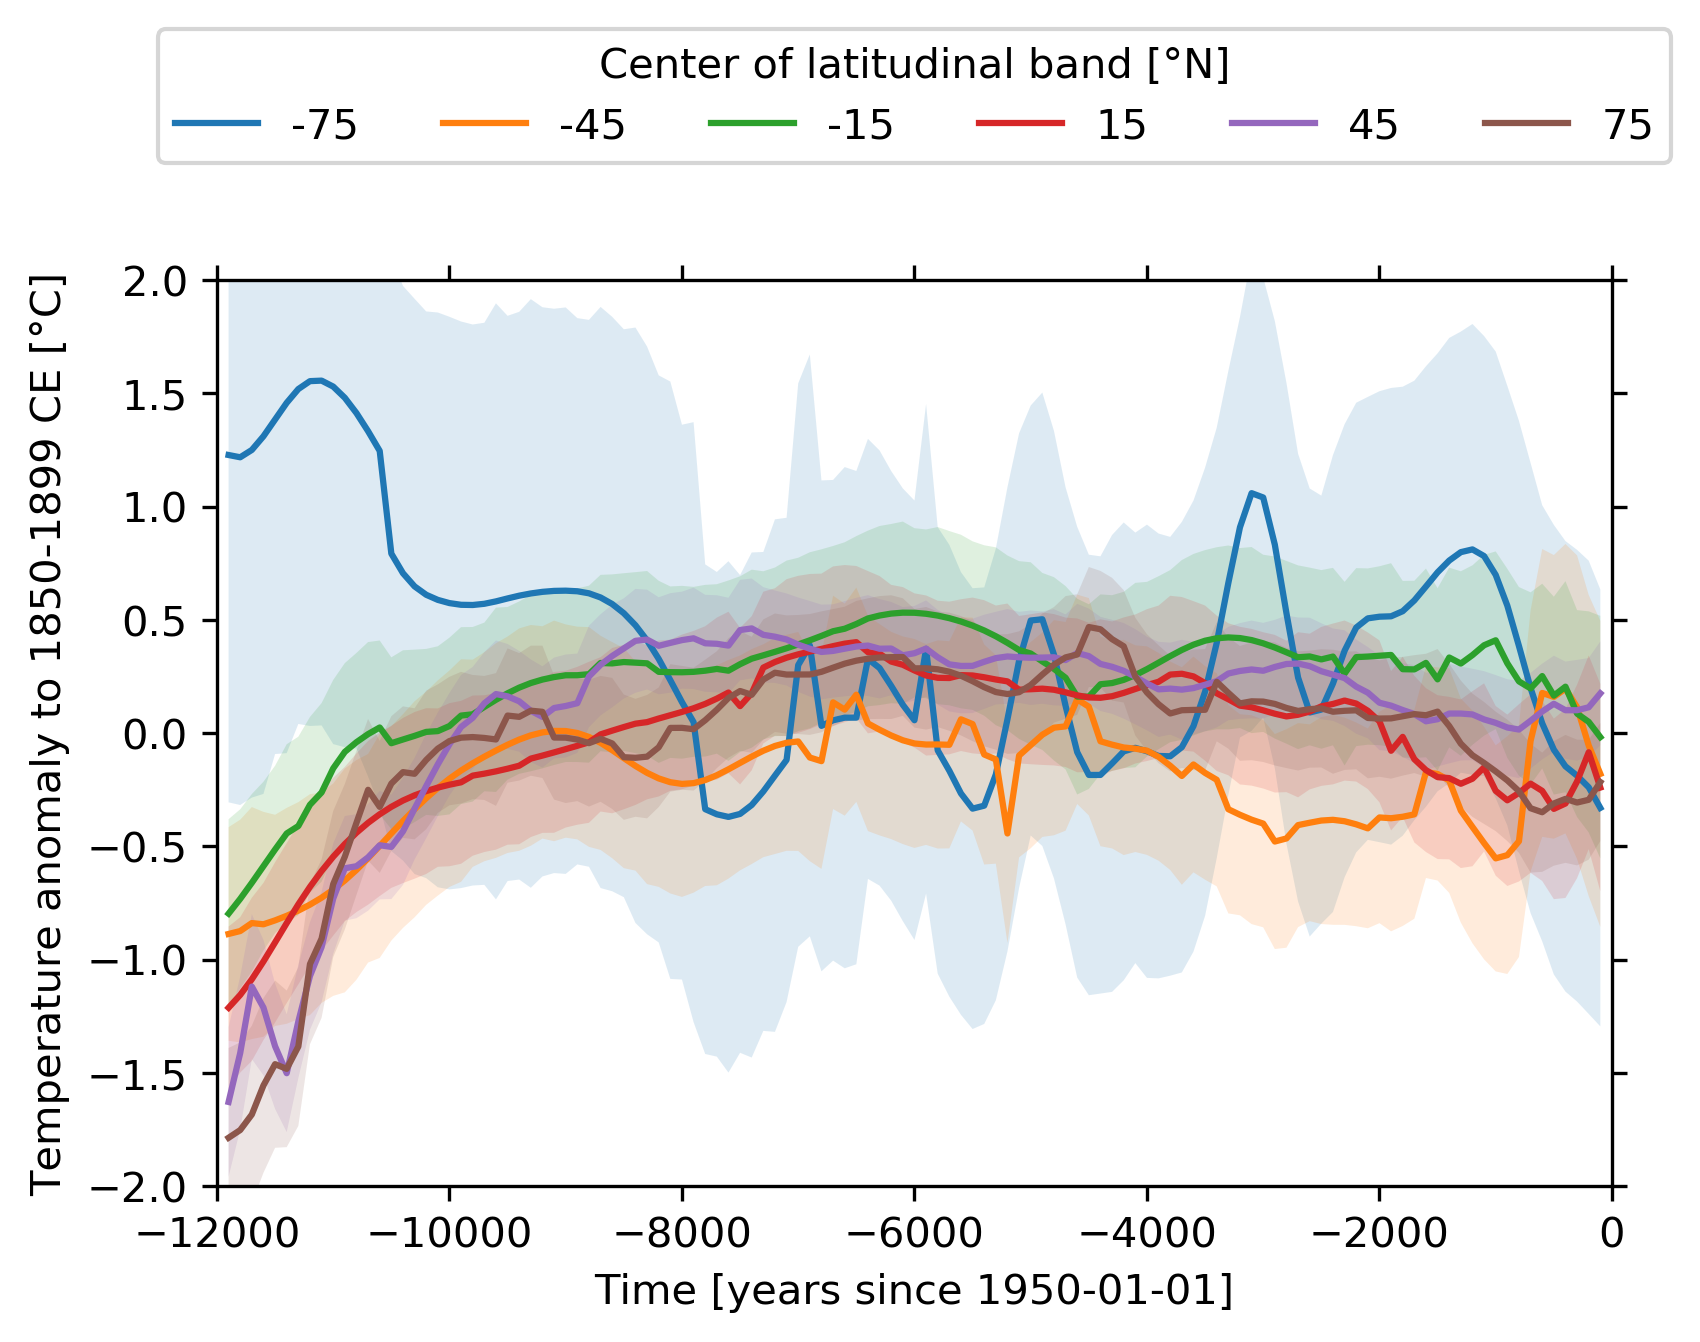

In [55]:
sp = bands.psy.plot.lineplot(
    name=[[['temperature', 'temperature_std']]],
    lat=list(range(6)), legendlabels='%(lat)s',
    xlabel='Time [years since 1950-01-01]',
    ylabel='Temperature anomaly to 1850-1899 CE [°C]',
    xlim='minmax', 
    legend=dict(loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.3),
                title='Center of latitudinal band [°N]'))

plt.gcf().set_dpi(300)

Compute the samples per band that have been used. There is an nsamples variable already in the file, but this one is based on the entire ensemble.

In [56]:
nsamples = ensemble.input_data.age.groupby_bins('lat', range(-90, 91, 30)).apply(
    lambda da: da.groupby_bins(da, np.arange(-50, 12051, 100)).apply(
        lambda da: xr.DataArray(np.unique(da.TSid).size)))
nsamples['lat_bins'] = ('lat_bins', [i.mid for i in nsamples.lat_bins.values])
nsamples['age_bins'] = ('age_bins', [i.mid for i in nsamples.age_bins.values])

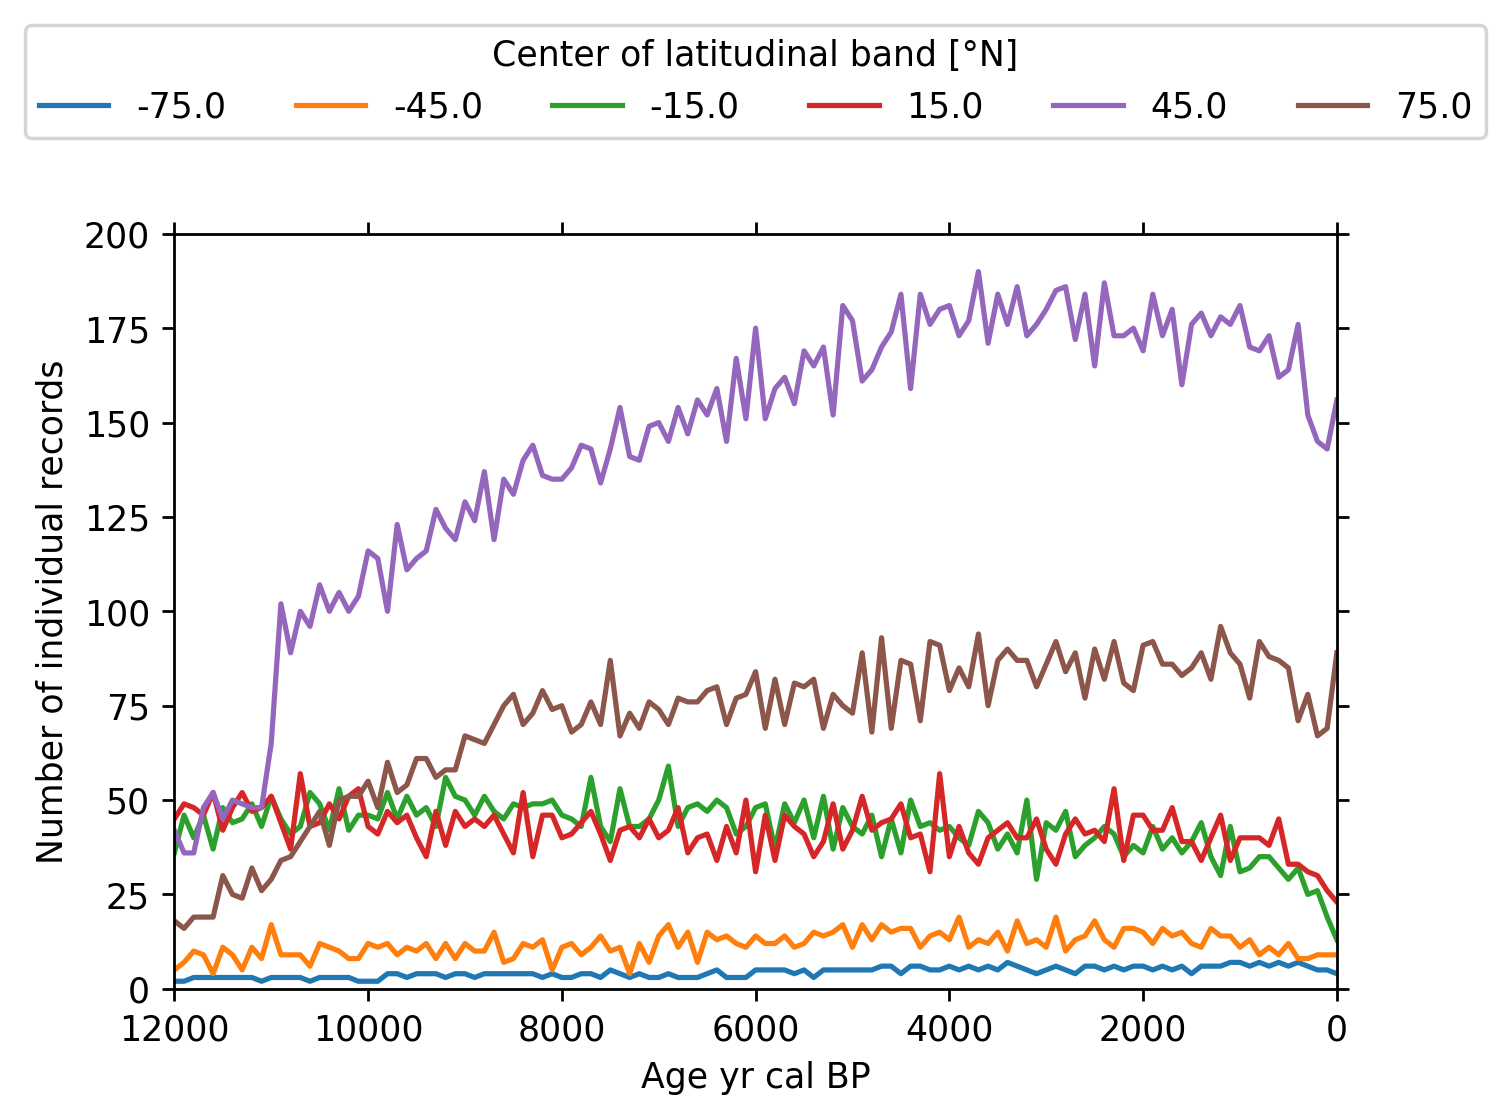

In [57]:
nsamples.to_dataset(name='nsamples').psy.plot.lineplot(
    lat_bins=list(range(6)), legendlabels='%(lat_bins)s',
    ylabel='Number of individual records', xlabel='Age yr cal BP',
    xlim='minmax', 
    legend=dict(loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.3),
                    title='Center of latitudinal band [°N]'))
plt.gcf().set_dpi(250)
plt.gca().invert_xaxis()

In [58]:
bands = bands.rename({'nsamples': 'nsamples_ens'})
bands['nsamples'] = nsamples.rename({'lat_bins': 'lat', 'age_bins': 'age'})

## Compute global mean

In [59]:
with warnings.catch_warnings() as c:
    warnings.filterwarnings('ignore', '\s*Mean of empty slice')
    glob_mean = output.mean('cell')

    # compute the sum for the number of samples and the cell_area
    glob_mean['nsamples'] = output.nsamples.sum('cell')
    glob_mean['cell_area'] = output.cell_area.sum('cell')

In [60]:
glob_mean['temperature_std'] = glob_mean.temperature_samples.std('ens')

/gpfs/home/sommerp/miniconda3/envs/temperature12k/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


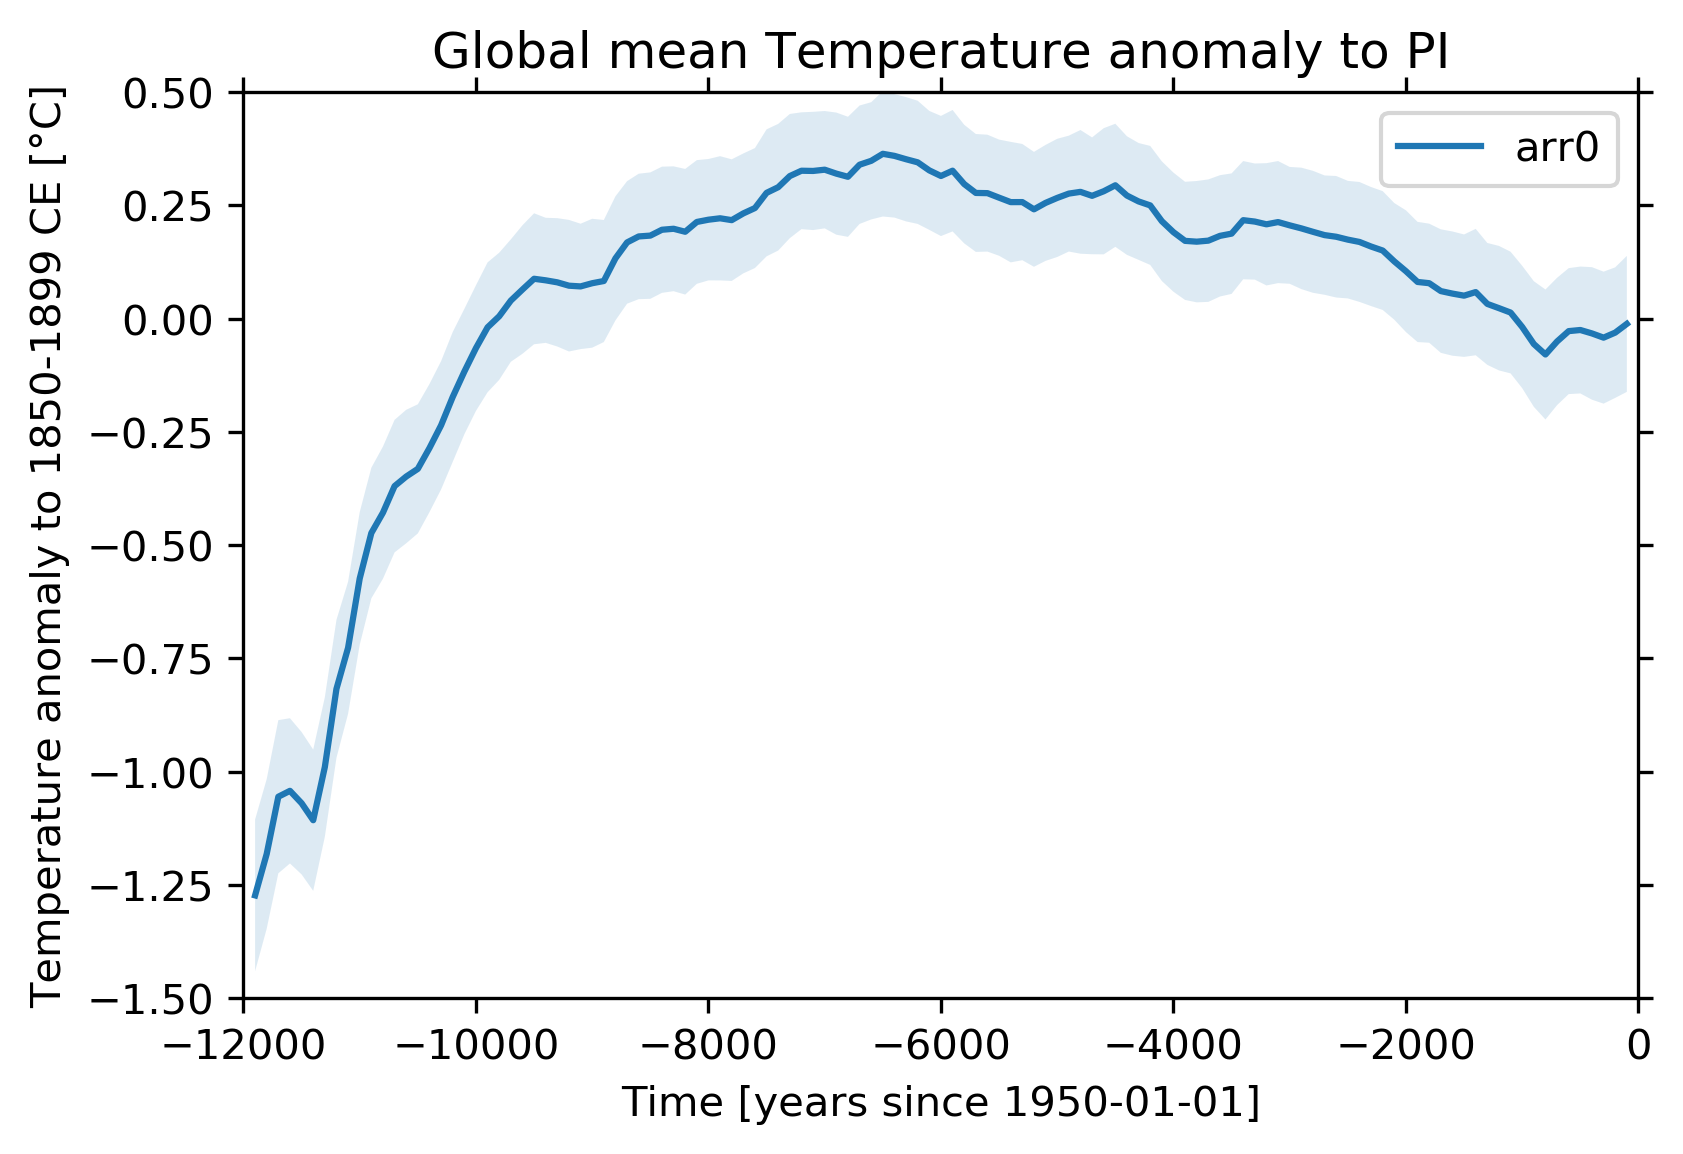

In [61]:
sp = glob_mean.psy.plot.lineplot(
    name=[[['temperature', 'temperature_std']]],
    title='Global mean Temperature anomaly to PI',
    xlabel='Time [years since 1950-01-01]',
    ylabel='Temperature anomaly to 1850-1899 CE [°C]',
    xlim='minmax')

plt.gcf().set_dpi(300)

## Export CSV file

In [62]:
out_df = output.drop_dims(['ens', 'bnds']).to_dataframe().dropna(subset=['temperature'])
out_df.reset_index(inplace=True)
out_df.set_index(['clon', 'clat'], inplace=True)

in_df = ensemble.input_data.drop_dims('ens').to_dataframe().drop_duplicates('TSid')
in_df.reset_index(inplace=True)
in_df.set_index(['clon', 'clat'], inplace=True)
del in_df['age'], in_df['temperature']

# add link to lipdverse
lipdverse_uri = f'http://lipdverse.org/globalHolocene/{db_version}/'
in_df['lipdverse'] = lipdverse_uri + in_df.dataSetName + '.html'

out_df = out_df.join(in_df, how='right').dropna(subset=['temperature'])

Merge pi anomaly

In [63]:
out_df.reset_index(inplace=True)
out_df.sort_values(['clon', 'clat', 'TSid', 'time'], inplace=True)
out_df.set_index(['clon', 'clat'], inplace=True)

In [64]:
clat = out_df.reset_index('clat').clat
out_df['band'] = np.asarray(clat - (clat % 30) + 15)
for band, group in out_df.groupby('band'):
    group.to_csv(f'{output_dir}/{key}-{band:1.0f}degN.tsv', '\t')

In [65]:
output.sel(time=-100).temperature_samples.std('ens').mean().values

/gpfs/home/sommerp/miniconda3/envs/temperature12k/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


array(2.1827287)

## Reconstructed temperature anomaly at 100 cal BP

/gpfs/home/sommerp/miniconda3/envs/temperature12k/lib/python3.7/site-packages/xarray/plot/plot.py:422: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  primitive = ax.hist(no_nan, **kwargs)


Text(0, 0.5, 'Density')

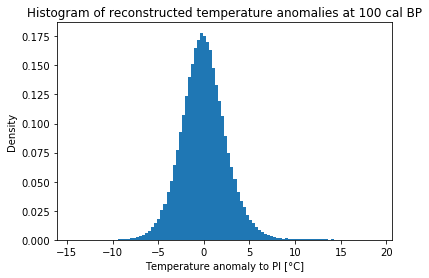

In [66]:
output.sel(time=-100).temperature_samples.plot.hist(bins=100, normed=True);
plt.title('Histogram of reconstructed temperature anomalies at 100 cal BP')
plt.xlabel('Temperature anomaly to PI [°C]')
plt.ylabel('Density')

## Export only grid cells with data

In [67]:
notnull = output.where(output.temperature.notnull().any('time'), drop=True)

## Add metadata to the output netCDF file

In [68]:
notnull

<xarray.Dataset>
Dimensions:              (bnds: 4, cell: 294, ens: 1000, time: 121)
Coordinates:
    clon                 (cell) float64 107.0 -109.0 93.73 ... 3.391 -64.28
    clon_bnds            (cell, bnds) float64 99.77 114.2 ... -38.56 -89.99
    clat                 (cell) float64 -76.94 -76.94 -73.76 ... 80.11 86.53
    clat_bnds            (cell, bnds) float64 -78.52 -78.52 ... 88.19 88.19
  * time                 (time) int64 -12000 -11900 -11800 ... -200 -100 0
Dimensions without coordinates: bnds, cell, ens
Data variables:
    cell_area            (cell, time) float64 nan nan nan ... 1.112e+11 nan
    temperature          (time, cell) float64 nan nan nan nan ... nan nan nan
    temperature_samples  (time, ens, cell) float64 nan nan nan ... nan nan nan
    time_needed          (cell, time) float64 nan nan nan ... 23.13 23.13 nan
    nsamples             (time, cell) float64 nan nan nan nan ... nan nan nan
Attributes:
    CDI:          Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Mon Nov 04 19:20:40 2019: cdo gridarea dummy-equal-area-gri...
    CDO:          Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.d...

In [69]:
time_bnds = np.c_[notnull.time.values[:, np.newaxis], notnull.time.values[:, np.newaxis]]
time_bnds[:, 0] -= 50
time_bnds[:, 1] += 50

### Global attributes

In [70]:
ymin = notnull.time.values.min() + 1950
ymax = notnull.time.values.max() + 1950
tmin = "%i-01-01T00:00:00" % ymin
tmax = "%i-12-31T00:00:00" % ymax

notnull.attrs.clear()
notnull.attrs.update(dict(
    Conventions="CF-1.8",
    institution="Helmholtz-Zentrum Geesthacht, Institute of Coastal Research, Germany",
    title="GAM-based surface temperature anomaly reconstruction from Temperature12K",
    source="Temperature12k",
    creation_date=dt.datetime.now().isoformat(),
    originator="Philipp S. Sommer",
    contact="https://hcdc.hzg.de",
    crs="EPSG:4326",
    StartTime=tmin,
    StopTime=tmax,
    contact_email="philipp.sommer@hzg.de",
    PI="Basil A. S. Davis",
    contributor="Manuel Chevalier",
    geospatial_lon_min=float(notnull.clon_bnds.min()),
    geospatial_lon_max=float(notnull.clon_bnds.max()),
    geospatial_lat_min=float(notnull.clat_bnds.min()),
    geospatial_lat_max=float(notnull.clat_bnds.max()),
    licence="CC BY 4.0",
))

### Variables

In [71]:
temp_attrs = dict(
    standard_name="surface_temperature_anomaly",
    units="K",
    long_name="Temperature anomaly to PI (1850-1899)",
    cell_methods="time: mean",
)

notnull.temperature.attrs.update(temp_attrs)
notnull.temperature_samples.attrs.update(temp_attrs)

notnull.nsamples.attrs.update(dict(
    standard_name="number_of_observations",
    long_name="Number of samples within the corresponding time step",
    units="1",
    cell_methods="time: sum",
))

notnull.time_needed.attrs.update(dict(
    long_name="Required time for computation",
    units="s",
    cell_methods="time: sum",
))

for v in ["temperature", "temperature_samples", "nsamples", "time_needed"]:
    notnull[v].encoding["coordinates"] = "clat clon"

### Coordinates

In [72]:
notnull["time_bnds"] = (("time", "tbnds"), time_bnds, {"long_name": "time bounds", "units": notnull.time.units})
notnull.time.attrs["bounds"] = "time_bnds"
notnull.time.attrs["standard_name"] = "time"

notnull.clon_bnds.attrs.update(dict(
    long_name="Longitudinal grid cell boundaries",
    units=notnull.clon.units,
    standard_name="longitude",
))

notnull.clat_bnds.attrs.update(dict(
    long_name="Latitudinal grid cell boundaries",
    units=notnull.clat.units,
    standard_name="latitude",
))

notnull.clon.attrs["standard_name"] = "longitude"
notnull.clat.attrs["standard_name"] = "latitude"

In [73]:
notnull.to_netcdf(f'{output_dir}/tasanom_gridcells_GAM_{key}-ref-1850-1899-CE_{ymin}0101-{ymax}0101.nc')

## Compare to Kaufman et al., 2020

Now we compare to the band means of 

> Kaufman, D., McKay, N., Routson, C., Erb, M., Dätwyler, C., Sommer, P. S., Heiri, O., & Davis, B. (2020). Holocene global mean surface temperature, a multi-method reconstruction approach. Scientific Data, 7(1), 201. https://doi.org/10.1038/s41597-020-0530-7

In [74]:
temp12k_file = osp.join(output_dir, "temp12k_alldata.nc")

# download the file, if necessary
if not osp.exists(temp12k_file):
    uri = "https://www.ncei.noaa.gov/pub/data/paleo/reconstructions/kaufman2020/temp12k_alldata.nc"
    print(f"Downloading {uri}")
    request.urlretrieve(uri, temp12k_file)

In [75]:
temp12k = xr.open_dataset(temp12k_file).rename(ages="time", latbands="lat")

In [76]:
temp12k["lat"] = (
    "lat", np.arange(75, -90, -30), 
    {"units": "degrees_north", "long_name": "Center of latitudinal band"}
)
temp12k["time"] = (
    "time", np.arange(0, 12001, 100), 
    {"units": "year cal BP", "long_name": "Age"}
)

### Band means

In [77]:
band_variables = ["scc_latbands", "dcc_latbands", "gam_latbands"]

mean_temp12k = temp12k[band_variables].mean('ens').to_array("model").to_dataset(name="temperature")
mean_temp12k["temperature_std"] = temp12k[band_variables].std('ens').to_array("model")

mean_temp12k["model"] = mean_temp12k.model.str.replace("_latbands", "").str.upper()
mean_temp12k["temperature"] -= mean_temp12k["temperature"].interp(time=75)

/gpfs/home/sommerp/miniconda3/envs/temperature12k/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/gpfs/home/sommerp/miniconda3/envs/temperature12k/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [78]:
new_method = bands.expand_dims("model")[["temperature", "temperature_std"]]
new_method["model"] = ("model", ["This study"])
new_method["time"] = -new_method["time"]
new_method

<xarray.Dataset>
Dimensions:          (lat: 6, model: 1, time: 121)
Coordinates:
  * time             (time) int64 12000 11900 11800 11700 ... 300 200 100 0
  * lat              (lat) float64 -75.0 -45.0 -15.0 15.0 45.0 75.0
  * model            (model) <U10 'This study'
Data variables:
    temperature      (model, lat, time) float64 nan 1.228 1.218 ... -0.2158 nan
    temperature_std  (model, lat, time) float64 nan 1.534 1.535 ... 0.2606 nan

In [80]:
combined = xr.concat([new_method, mean_temp12k], "model")
combined.temperature.attrs.update(temp_attrs)
combined.temperature_std.attrs.update(temp_attrs)
combined.temperature_std.attrs["cell_methods"] += " ens: mean"
combined.temperature_std.attrs["long_name"] = (
    "Standard deviation of " + temp_attrs["long_name"]
)
combined.temperature_std.attrs["cell_methods"] += " ens: standard_deviation"

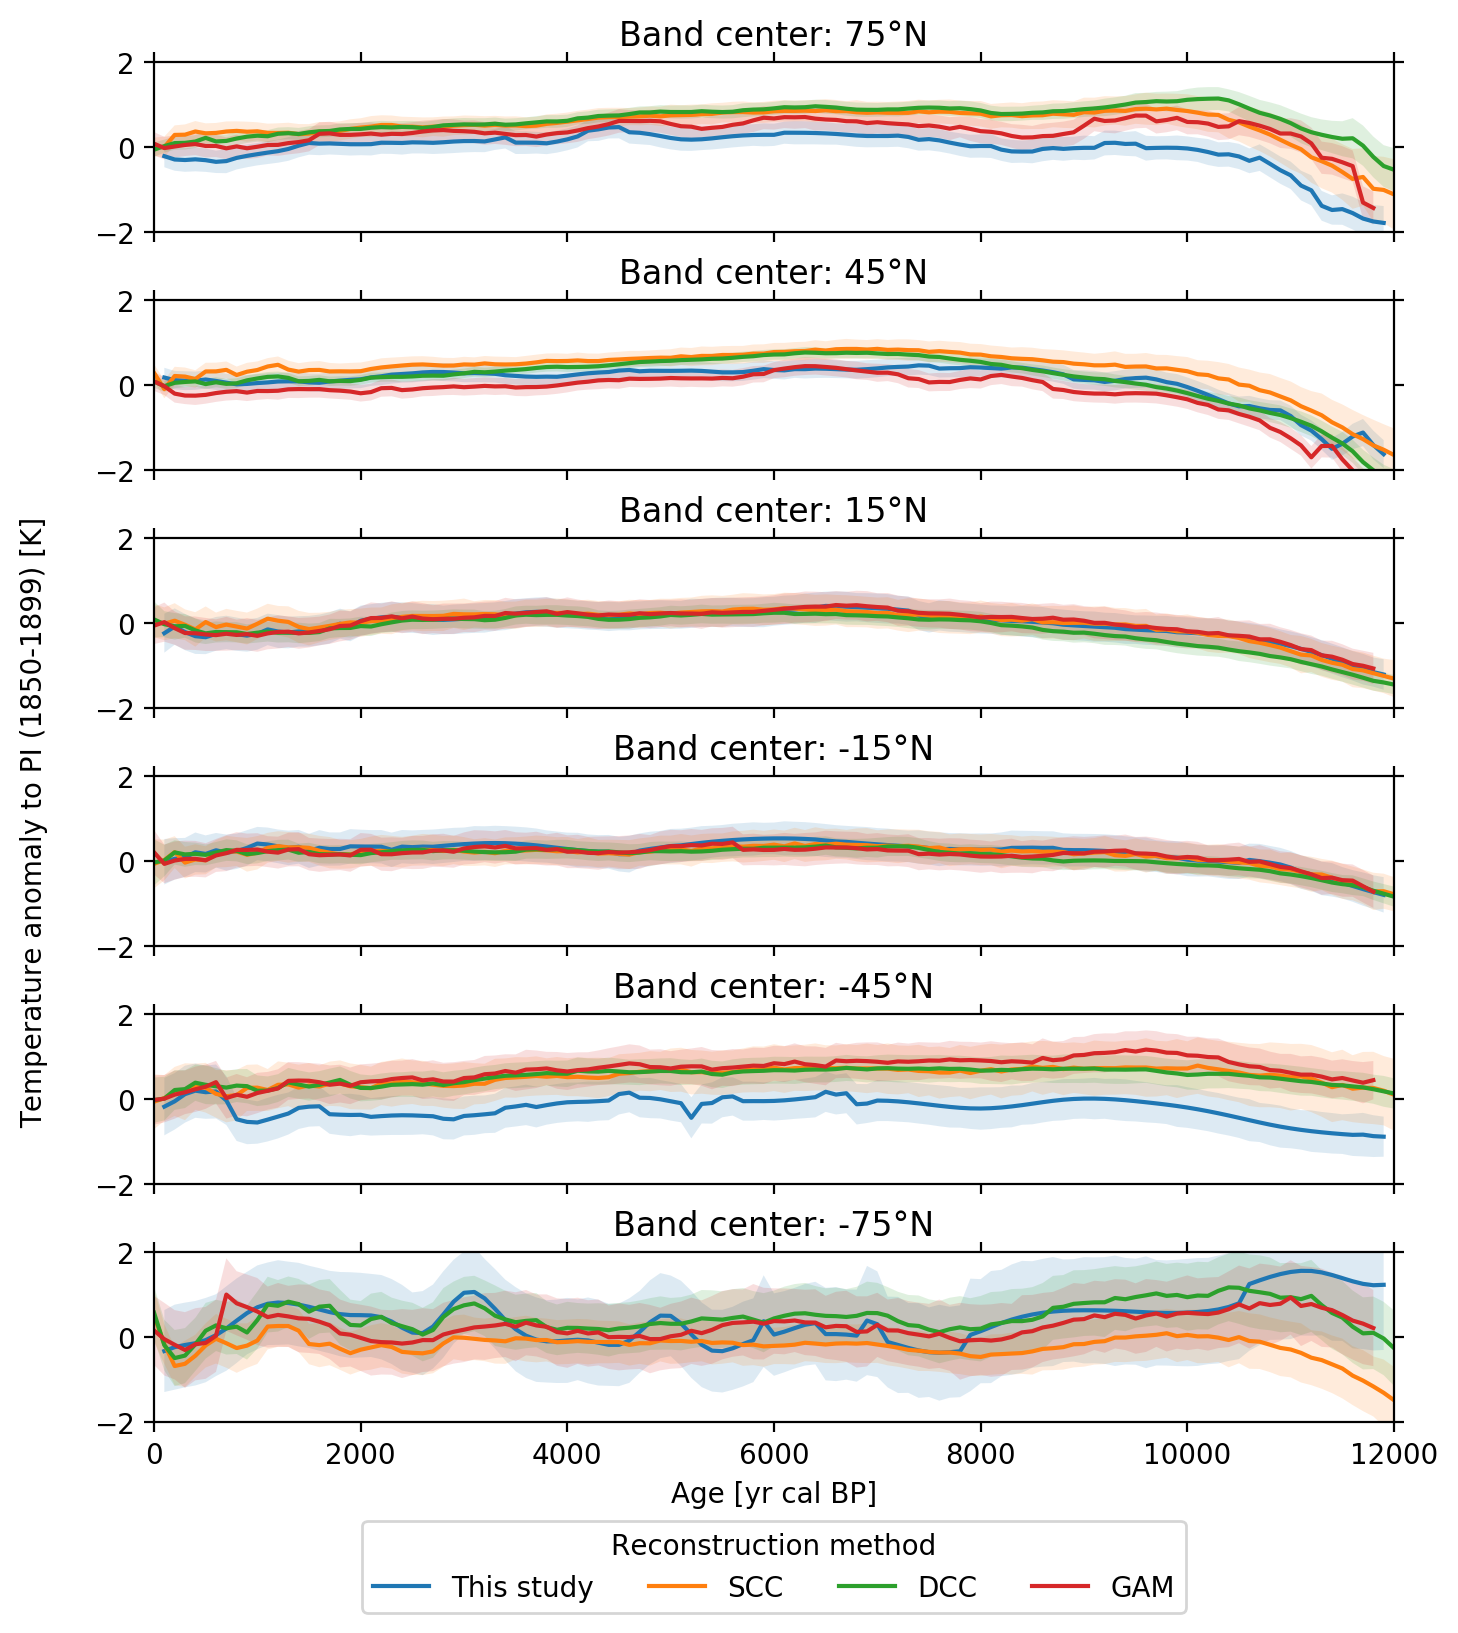

In [81]:
fig, axes = plt.subplots(6, 1, figsize=(8, 10))

legend_kws = dict(
    loc="upper center",
    ncol=4, 
    title="Reconstruction method",
    bbox_to_anchor=(0.5, -0.5),
)

for i, j in enumerate(reversed(range(combined.dims["lat"]))):
    last = j == 0
    combined.psy.plot.lineplot(
        name=[[["temperature", "temperature_std"]]], model=list(range(4)), lat=j,
        ax=axes[i],
        legendlabels="%(model)s",
        xlabel="" if not last else "Age [yr cal BP]",
        xticklabels="" if not last else None,
        xlim="minmax", title="Band center: %(lat)1.0f°N", 
        ylim=(-2, 2),
        legend=last and legend_kws)

fig.set_dpi(200)
fig.subplots_adjust(bottom=0.2, hspace=0.4)
fig.text(0.05, 0.5, combined.temperature.long_name + " [K]", 
         rotation=90, va="center", ha="center")
fig.savefig(osp.join(output_dir, "band-comparison-to-kaufman-2020.pdf"))

In [82]:
combined.attrs.update(dict(
    Conventions="CF-1.8",
    institution="Helmholtz-Zentrum Geesthacht, Institute of Coastal Research, Germany",
    title="Latitudinal bands of reconstructed surface temperature anomaly to PI",
    source="Temperature12k",
    creation_date=dt.datetime.now().isoformat(),
    originator="Philipp S. Sommer",
    contact="https://hcdc.hzg.de",
    crs="EPSG:4326",
    StartTime=tmin,
    StopTime=tmax,
    contact_email="philipp.sommer@hzg.de",
    PI="Basil A. S. Davis",
    contributor="Manuel Chevalier",
    licence="CC BY 4.0",
    comment=(
        "The model dimension with 'This study' uses the revised dataset. "
        "SCC, DCC and GAM are derived from "
        "Kaufman, D., McKay, N., Routson, C., Erb, M., Dätwyler, C., Sommer, P. S., Heiri, O., & Davis, B. (2020). "
        "Holocene global mean surface temperature, a multi-method reconstruction approach. "
        "Scientific Data, 7(1), 201. https://doi.org/10.1038/s41597-020-0530-7"
    )
))

In [83]:
combined.model.attrs.update(dict(
    long_name="Reconstruction method",
    comment=(
        "The model dimension with 'This study' uses the revised dataset. "
        "SCC, DCC and GAM are derived from the supplementary data in "
        "Kaufman et al., 2020, https://doi.org/10.1038/s41597-020-0530-7"
    )
))

In [84]:
combined["time"] *= -1

In [85]:
combined.to_netcdf(f'{output_dir}/tasanom_band-means_all-models_{key}-ref-1850-1899-CE_{ymin}0101-{ymax}0101.nc')

### Global mean

In [86]:
glob_mean_variables = ["scc_globalmean", "dcc_globalmean", "gam_globalmean"]

mean_temp12k = temp12k[glob_mean_variables].mean('ens').to_array("model").to_dataset(name="temperature")
mean_temp12k["temperature_std"] = temp12k[glob_mean_variables].std('ens').to_array("model")

mean_temp12k["model"] = mean_temp12k.model.str.replace("_globalmean", "").str.upper()
mean_temp12k["temperature"] -= mean_temp12k["temperature"].interp(time=75)

/gpfs/home/sommerp/miniconda3/envs/temperature12k/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/gpfs/home/sommerp/miniconda3/envs/temperature12k/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [87]:
new_method = glob_mean.expand_dims("model")[["temperature", "temperature_std"]]
new_method["model"] = ("model", ["This study"])
new_method["time"] = -new_method["time"]
new_method

<xarray.Dataset>
Dimensions:          (model: 1, time: 121)
Coordinates:
  * time             (time) int64 12000 11900 11800 11700 ... 300 200 100 0
  * model            (model) <U10 'This study'
Data variables:
    temperature      (model, time) float64 nan -1.273 -1.182 ... -0.01151 nan
    temperature_std  (model, time) float64 nan 0.1675 0.1651 ... 0.1501 nan

In [88]:
combined

<xarray.Dataset>
Dimensions:          (lat: 6, model: 4, time: 121)
Coordinates:
  * time             (time) int64 0 -100 -200 -300 ... -11800 -11900 -12000
  * lat              (lat) float64 -75.0 -45.0 -15.0 15.0 45.0 75.0
  * model            (model) object 'This study' 'SCC' 'DCC' 'GAM'
Data variables:
    temperature      (model, lat, time) float64 nan -0.33 -0.2389 ... nan nan
    temperature_std  (model, lat, time) float64 nan 0.9647 1.001 ... nan nan
Attributes:
    Conventions:    CF-1.8
    institution:    Helmholtz-Zentrum Geesthacht, Institute of Coastal Resear...
    title:          Latitudinal bands of reconstructed surface temperature an...
    source:         Temperature12k
    creation_date:  2020-10-02T21:57:24.037940
    originator:     Philipp S. Sommer
    contact:        https://hcdc.hzg.de
    crs:            EPSG:4326
    StartTime:      -10050-01-01T00:00:00
    StopTime:       1950-12-31T00:00:00
    contact_email:  philipp.sommer@hzg.de
    PI:             Basil A. S. Davis
    contributor:    Manuel Chevalier
    licence:        CC BY 4.0
    comment:        The model dimension with 'This study' uses the revised da...

In [89]:
combined = xr.concat([new_method, mean_temp12k], "model")
combined.temperature.attrs.update(temp_attrs)
combined.temperature_std.attrs.update(temp_attrs)
combined.temperature_std.attrs["cell_methods"] += " ens: mean"
combined.temperature_std.attrs["long_name"] = (
    "Standard deviation of " + temp_attrs["long_name"]
)
combined.temperature_std.attrs["cell_methods"] += " ens: standard_deviation"

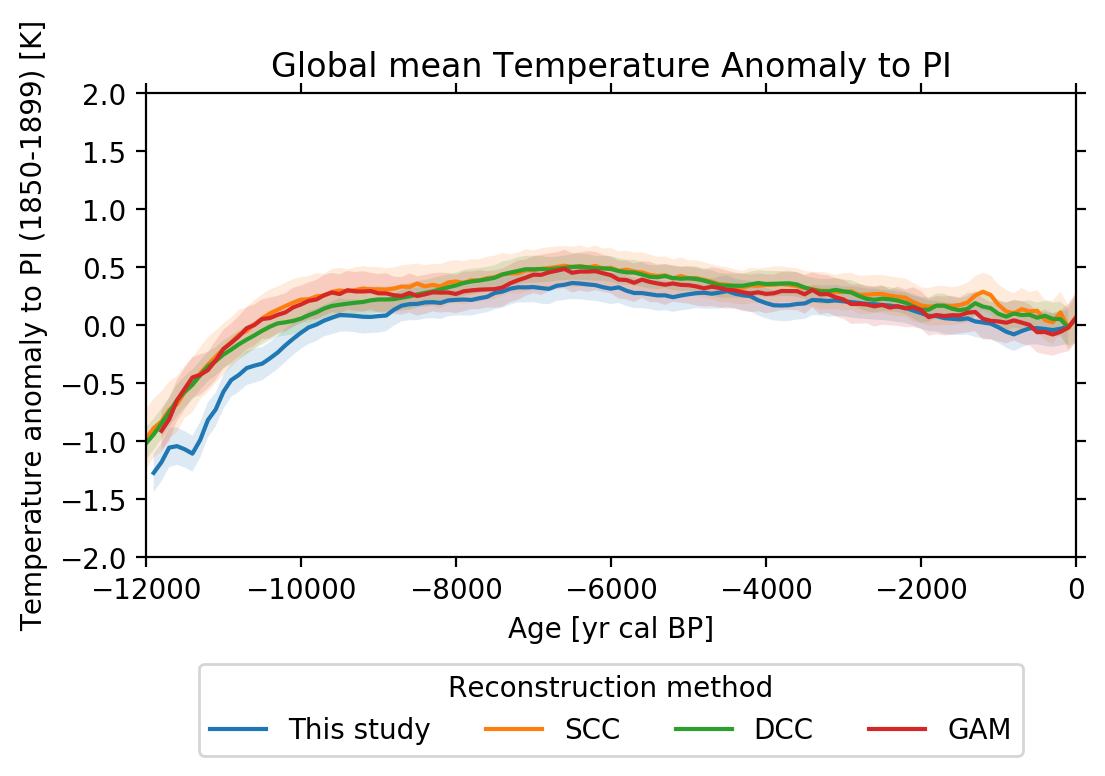

In [111]:
legend_kws = dict(
    loc="upper center",
    ncol=4, 
    title="Reconstruction method",
    bbox_to_anchor=(0.5, -0.2),
)

sp = combined.psy.plot.lineplot(
    name=[[["temperature", "temperature_std"]]], model=list(range(4)),
    legendlabels="%(model)s",
    xlabel="" if not last else "Age [yr cal BP]",
    xticklabels="" if not last else None,
    xlim="minmax", title="Global mean Temperature Anomaly to PI", 
    ylim=(-2, 2),
    ylabel="{desc}",
    legend=legend_kws)

fig = list(sp.figs)[0]

fig.set_dpi(200)
fig.subplots_adjust(bottom=0.3, hspace=0.4)
fig.savefig(osp.join(output_dir, "global-mean-comparison-to-kaufman-2020.pdf"))

In [103]:
combined.attrs.update(dict(
    Conventions="CF-1.8",
    institution="Helmholtz-Zentrum Geesthacht, Institute of Coastal Research, Germany",
    title="Global mean of reconstructed surface temperature anomaly to PI",
    source="Temperature12k",
    creation_date=dt.datetime.now().isoformat(),
    originator="Philipp S. Sommer",
    contact="https://hcdc.hzg.de",
    crs="EPSG:4326",
    StartTime=tmin,
    StopTime=tmax,
    contact_email="philipp.sommer@hzg.de",
    PI="Basil A. S. Davis",
    contributor="Manuel Chevalier",
    licence="CC BY 4.0",
    comment=(
        "The model dimension with 'This study' uses the revised dataset. "
        "SCC, DCC and GAM are derived from "
        "Kaufman, D., McKay, N., Routson, C., Erb, M., Dätwyler, C., Sommer, P. S., Heiri, O., & Davis, B. (2020). "
        "Holocene global mean surface temperature, a multi-method reconstruction approach. "
        "Scientific Data, 7(1), 201. https://doi.org/10.1038/s41597-020-0530-7"
    )
))

In [104]:
combined.model.attrs.update(dict(
    long_name="Reconstruction method",
    comment=(
        "The model dimension with 'This study' uses the revised dataset. "
        "SCC, DCC and GAM are derived from the supplementary data in "
        "Kaufman et al., 2020, https://doi.org/10.1038/s41597-020-0530-7"
    )
))

In [105]:
combined["time"] *= -1

In [106]:
combined.to_netcdf(f'{output_dir}/tasanom_global-mean_all-models_{key}-ref-1850-1899-CE_{ymin}0101-{ymax}0101.nc')